In [1]:
import numpy as np
import sys, os

import gudhi as gd
import gudhi.representations

from sklearn.manifold import Isomap,MDS
from gmplabtools.pamm import PammGMM, PammGMM

sys.path.append('../')
from tools import plot_tools as myplt
from tools import topo_tools as mytop

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Molecular descriptor and Unsupervised clustering approach

Spiego veloce

## Dataset

In [3]:
def get_clusterCenters(data_file):
    centers_ = PammGMM.read_clusters(data_file).mean_k
    return np.vstack(centers_)

In [9]:
LABEL_SIZE = 16
SAVE_PLOT = True

In [5]:
SOAP_DIR='/home/andreag/SOFTSYSTEMS/BETAHAIRPIN/soap_files/rcut12'
SOAPloc = np.load(SOAP_DIR+'/SOAP_betahairpin_CA_rcut12_trj0-1000-1.npy')
SOAPave = np.load(SOAP_DIR+'/SOAP_AVE_betahairpin_CA_rcut12_trj0-1000-1.npy')

In [6]:
PCA_DIR='/home/andreag/SOFTSYSTEMS/BETAHAIRPIN/pca_files/rcut12'
PCAloc = np.loadtxt(PCA_DIR+'/PCA_betahairpin_CA_rcut12_trj0-1000-1_INDIVIDUAL.pca')
PCAave = np.loadtxt(PCA_DIR+'/PCA_AVE_betahairpin_CA_rcut12_trj0-1000-1_INDIVIDUAL.pca')

In [7]:
SYST = {
    'soap_loc' : SOAPloc,
    'soap_ave' : SOAPave,
    'pca_loc'  : PCAloc,
    'pca_ave'  : PCAave
}

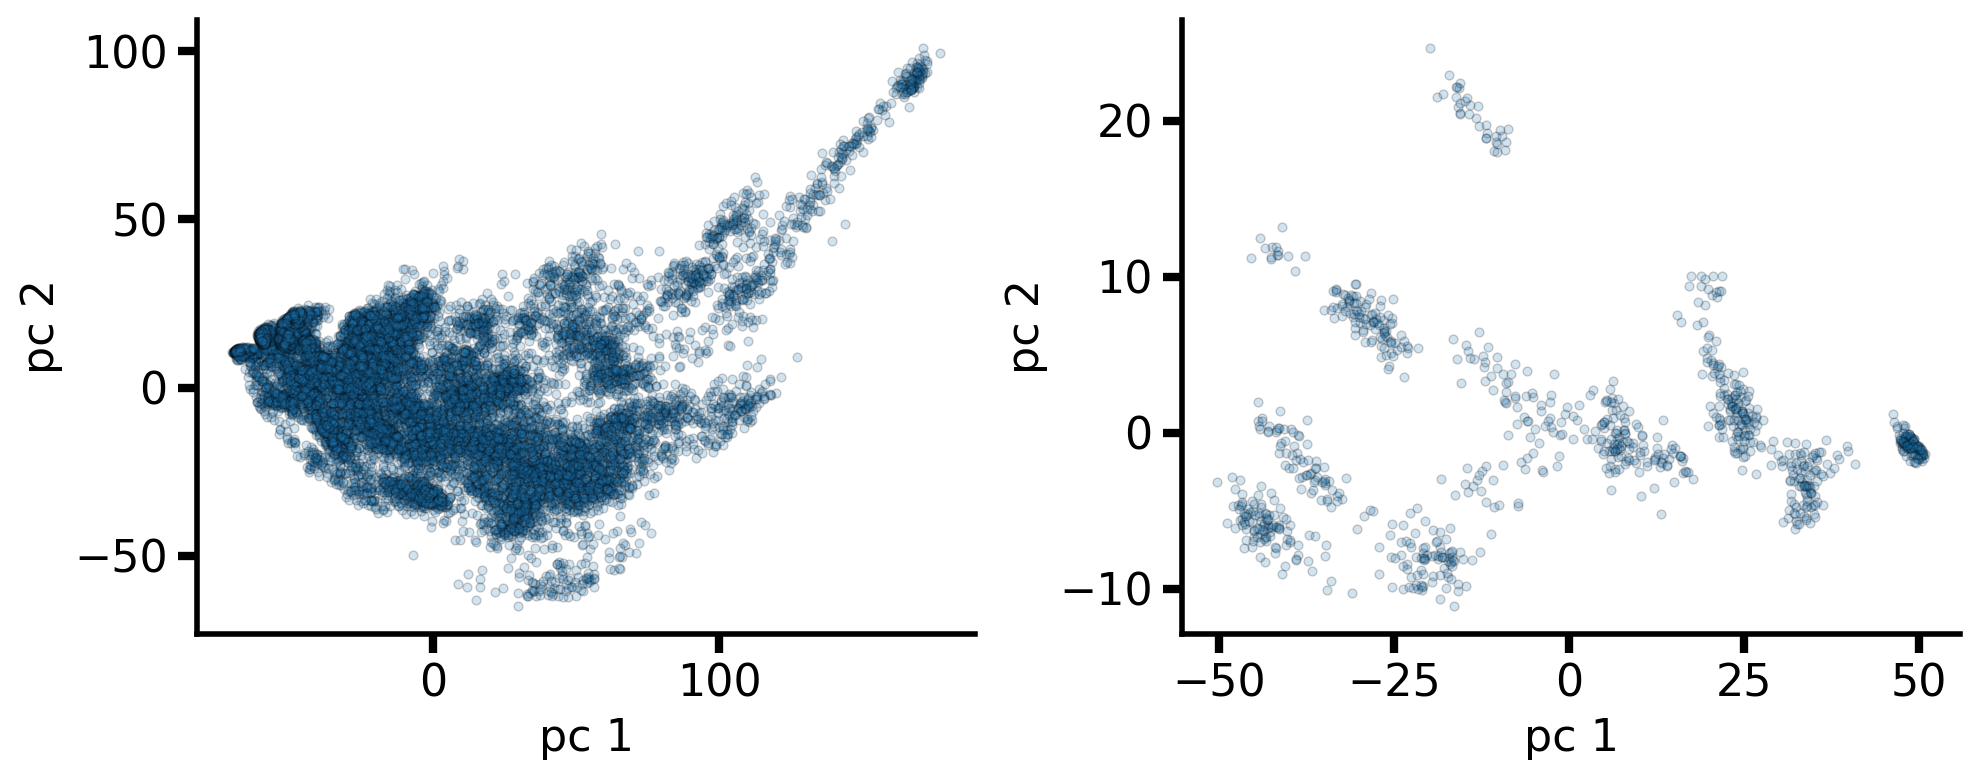

In [10]:
fig, ax = myplt.get_axes(2, max_col=2, res=200)

pca_loc = myplt.single_scatter_axe(SYST['pca_loc'], ax[0], alpha=0.2)
pca_ave = myplt.single_scatter_axe(SYST['pca_ave'], ax[1], alpha=0.2)

for i in range(2):
    ax[i].set_xlabel('pc 1', size=LABEL_SIZE)
    ax[i].set_ylabel('pc 2', size=LABEL_SIZE)
    ax[i].tick_params(labelsize=LABEL_SIZE,width=3,size=7)
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("data_set_pcas.svg")

## Unsupervised clustering

spiego?

### Global analysis (SOAP average)

In [11]:
PAMM_DIR = '/home/andreag/phd_AG/CLUSTERINGanalysys/BETAHAIRPIN/rcut12/'

In [12]:
pammLabelsAve = np.loadtxt(PAMM_DIR+'sys2_clusters.dat').astype(int)
clusterCentersAve = get_clusterCenters(data_file=PAMM_DIR+'pamm_sys2.pamm')

In [13]:
NclustersAve = len(clusterCentersAve)
print(f"There are {NclustersAve} clusters (PAMM algorithm)")

There are 8 clusters (PAMM algorithm)


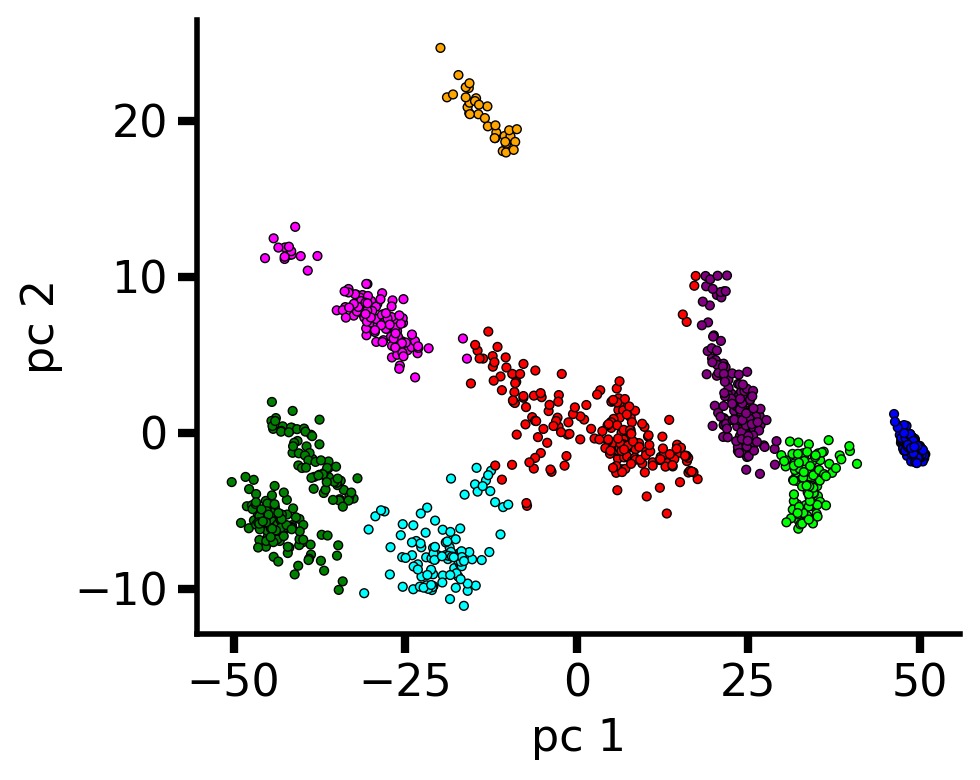

In [14]:
PALETTE = ['blue', 'green', 'red', 'orange', 'cyan', 'purple', 'magenta', 'lime'] #to match vmd
fig, ax = myplt.get_axes(1, max_col=1, res=200)
myplt.single_scatter_axe(SYST['pca_ave'], axes=ax,
                         color=np.array(PALETTE)[pammLabelsAve],
                         alpha=1)
ax.set_xlabel('pc 1', size=LABEL_SIZE)
ax.set_ylabel('pc 2', size=LABEL_SIZE)
ax.tick_params(labelsize=LABEL_SIZE,width=3,size=7)

fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("pca_ave_pamm_clustering.svg")

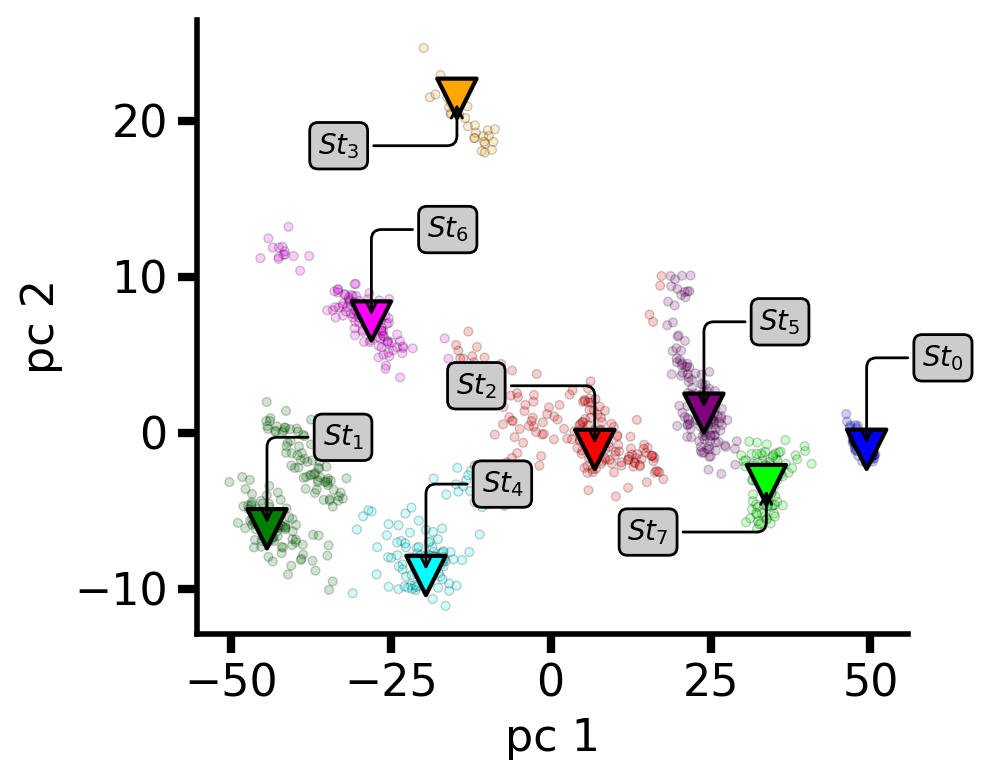

In [16]:
labels = [r'$St_{'+str(i)+'}$' for i in range(len(clusterCentersAve))]
annotyx = [[20, 30],[20, 30],[-50, 20],[-50, -20],[20, 30],[20, 30],[20, 30],[-50, -20]]

fig, ax = myplt.get_axes(1, max_col=1, res=200)
myplt.single_scatter_axe(SYST['pca_ave'], axes=ax,
                         color=np.array(PALETTE)[pammLabelsAve],
                         alpha=0.2)
ax.set_xlabel('pc 1', size=LABEL_SIZE)
ax.set_ylabel('pc 2', size=LABEL_SIZE)
ax.tick_params(labelsize=LABEL_SIZE,width=3,size=7)

ax.scatter(clusterCentersAve[:,0], clusterCentersAve[:,1],
           s=200, edgecolor='k', linewidth=1.5, marker='v',
           c=np.array(PALETTE))

for i, txt in enumerate(labels):
    ax.annotate(txt, (clusterCentersAve[i,0],clusterCentersAve[i,1]),
                xytext=annotyx[i], textcoords='offset points',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"))

fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("pca_ave_pamm_clustering_centers.svg")

### Structural fingerprints

In [17]:
def get_AveStructuresFrames(data, cluster_centers):
    frames = list()
    for cl in cluster_centers:
        frames += [i for i, j in enumerate(np.around(data, decimals=4)) if j[0] == np.around(cl[0], decimals=4)]
    return frames

In [18]:
structure_frames = get_AveStructuresFrames(SYST['pca_ave'], clusterCentersAve)
print(structure_frames)

[186, 770, 563, 822, 259, 885, 489, 396]


<img src="imgs/fingerprint.png" width="700px" align="center" alt="aux">

### SOAP metric

In [19]:
# kernel SOAP , aka superposition of the soap, 1= identical, 0= most different
def SOAPkernel(A,B,n=1):
    return ( np.dot(A, B) / (np.dot(A, A) * np.dot(B, B))**0.5 )**n

def SOAPdistance(ABker):
    np.seterr(all='raise')
    try:
        (2.0 - 2.0*ABker)**0.5
    except FloatingPointError:
        return 0
    
    return (2.0 - 2.0*ABker)**0.5

In [24]:
distEmbeddingISO = Isomap(n_components=2,
                   metric='precomputed')
distEmbeddingMDS = MDS(n_components=2,
                    dissimilarity='precomputed')

### Global analysis (SOAP average)

In [25]:
UNIT = 16
labels_ = ['St_'+str(i) for i in range(len(clusterCentersAve))]

In [26]:
StrSoapGL = dict()
for i,frame in enumerate(structure_frames):
    StrSoapGL[labels_[i]] = SOAPave[frame]
StrSoapGL.keys()

dict_keys(['St_0', 'St_1', 'St_2', 'St_3', 'St_4', 'St_5', 'St_6', 'St_7'])

In [27]:
l = len(StrSoapGL)
print(f"Number of systems: {l}")
soapDistGL = np.zeros((l, l))
for i in range(l):
    for j in range(i):
        soapDistGL[i,j] = SOAPdistance(SOAPkernel(StrSoapGL['St_'+str(i)], StrSoapGL['St_'+str(j)]))
        
soapDistGL = soapDistGL + soapDistGL.transpose()

Number of systems: 8


In [33]:
pos = distEmbeddingMDS.fit_transform(soapDistGL)

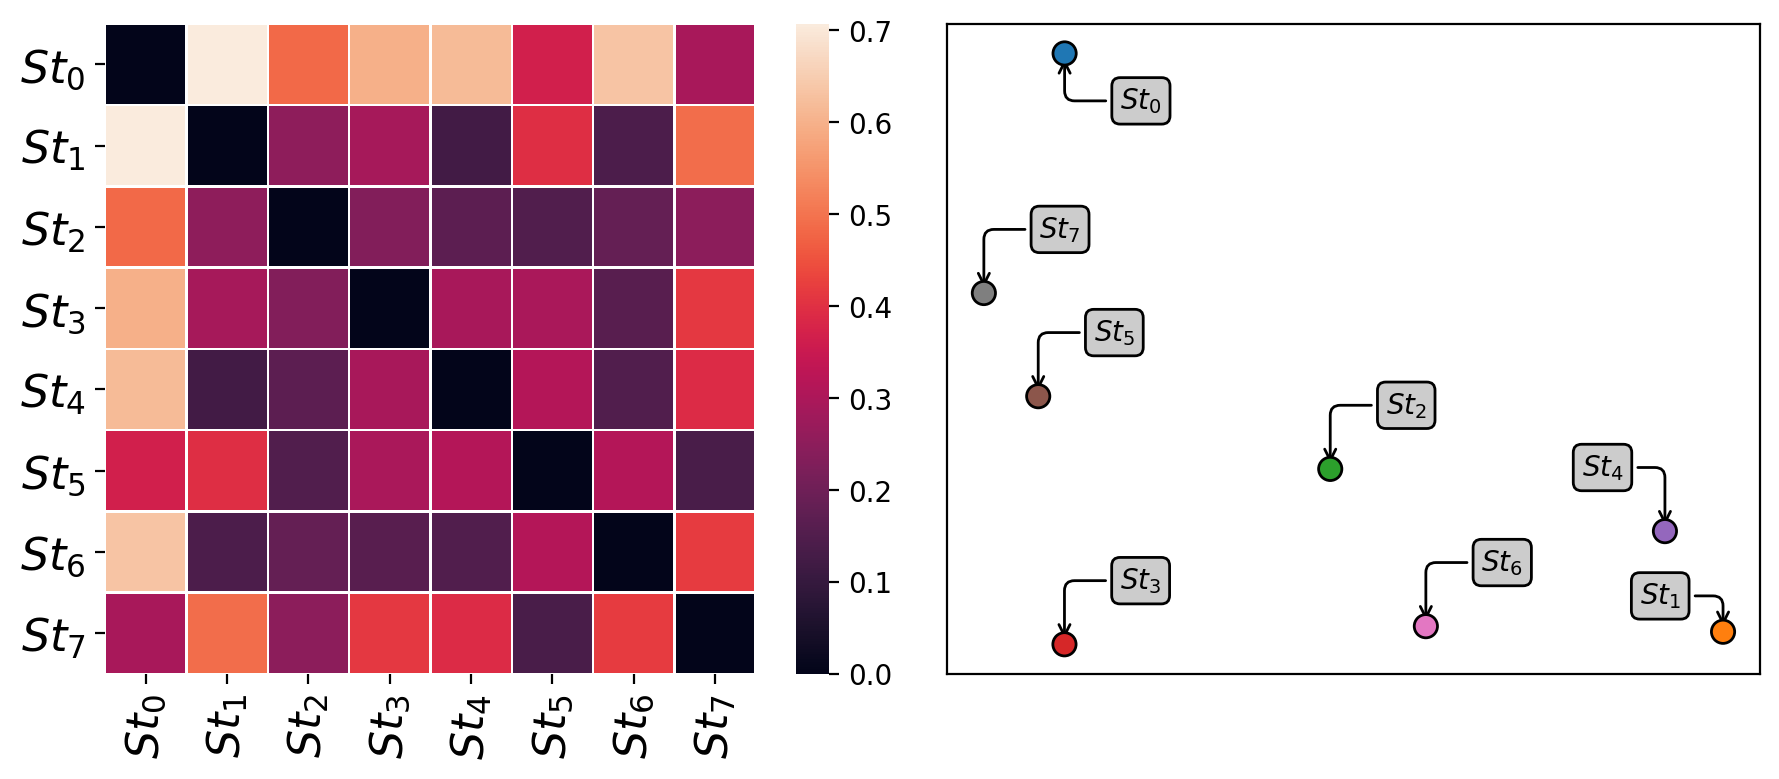

In [51]:
annotyx = [[20, -20],[-30, 10],[20, 20],[20, 20],[-30, 20],[20, 20],[20, 20],[20, 20]]
cm = myplt.myPalette(len(labels), palette='tab10')

fig, ax = myplt.get_axes(2, max_col=2, res=200, fig_frame=(4.5,4))

hm = sns.heatmap(soapDistGL, ax=ax[0], 
                 xticklabels=labels, yticklabels=labels,
#                  annot=True, fmt=".2f",
#                  cbar=False,
                 linewidths=.5, linecolor='w'
                )

hm.set_xticklabels(hm.get_xticklabels(), rotation=90, fontsize = 16)
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, fontsize = 16)

ax[1].scatter(pos[:,0], pos[:,1], alpha=1, s=70, zorder=10,
           edgecolor='k', color=np.array(cm))

for i, txt in enumerate(labels):
    ax[1].annotate(txt, (pos[i,0],pos[i,1]),
#                    fontsize=20,
                   xytext=annotyx[i], textcoords='offset points',
                   bbox=dict(boxstyle="round", fc="0.8"),
                   arrowprops=dict(arrowstyle="->",
                                   connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].xaxis.set_ticks_position('none')
ax[1].yaxis.set_ticks_position('none')
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("soapave_distmatrix_mds.svg")

### Local analysis

From the list of frames of the previous analysis

In [52]:
UNIT = 16
StrSoapLoc = dict()
for i,frame in enumerate(structure_frames):
    StrSoapLoc[labels_[i]] = SOAPloc[frame*UNIT:frame*UNIT+UNIT]
StrSoapLoc.keys()

dict_keys(['St_0', 'St_1', 'St_2', 'St_3', 'St_4', 'St_5', 'St_6', 'St_7'])

In [53]:
StrSoapLoc['St_0'].shape

(16, 324)

In [54]:
StrSoapLoc_matrix = dict()
l = len(StrSoapLoc)
print(f"Number of systems: {l}")

for s in range(l):
    l_ = StrSoapLoc[labels_[s]].shape[0]
    matrix_ = np.zeros((l_, l_))
    
    for i in range(l_):
        for j in range(i):
            matrix_[i,j] = SOAPdistance(SOAPkernel(StrSoapLoc[labels_[s]][i], StrSoapLoc[labels_[s]][j]))

    matrix_ = matrix_ + matrix_.transpose()
    
    StrSoapLoc_matrix[labels_[s]] = matrix_

Number of systems: 8


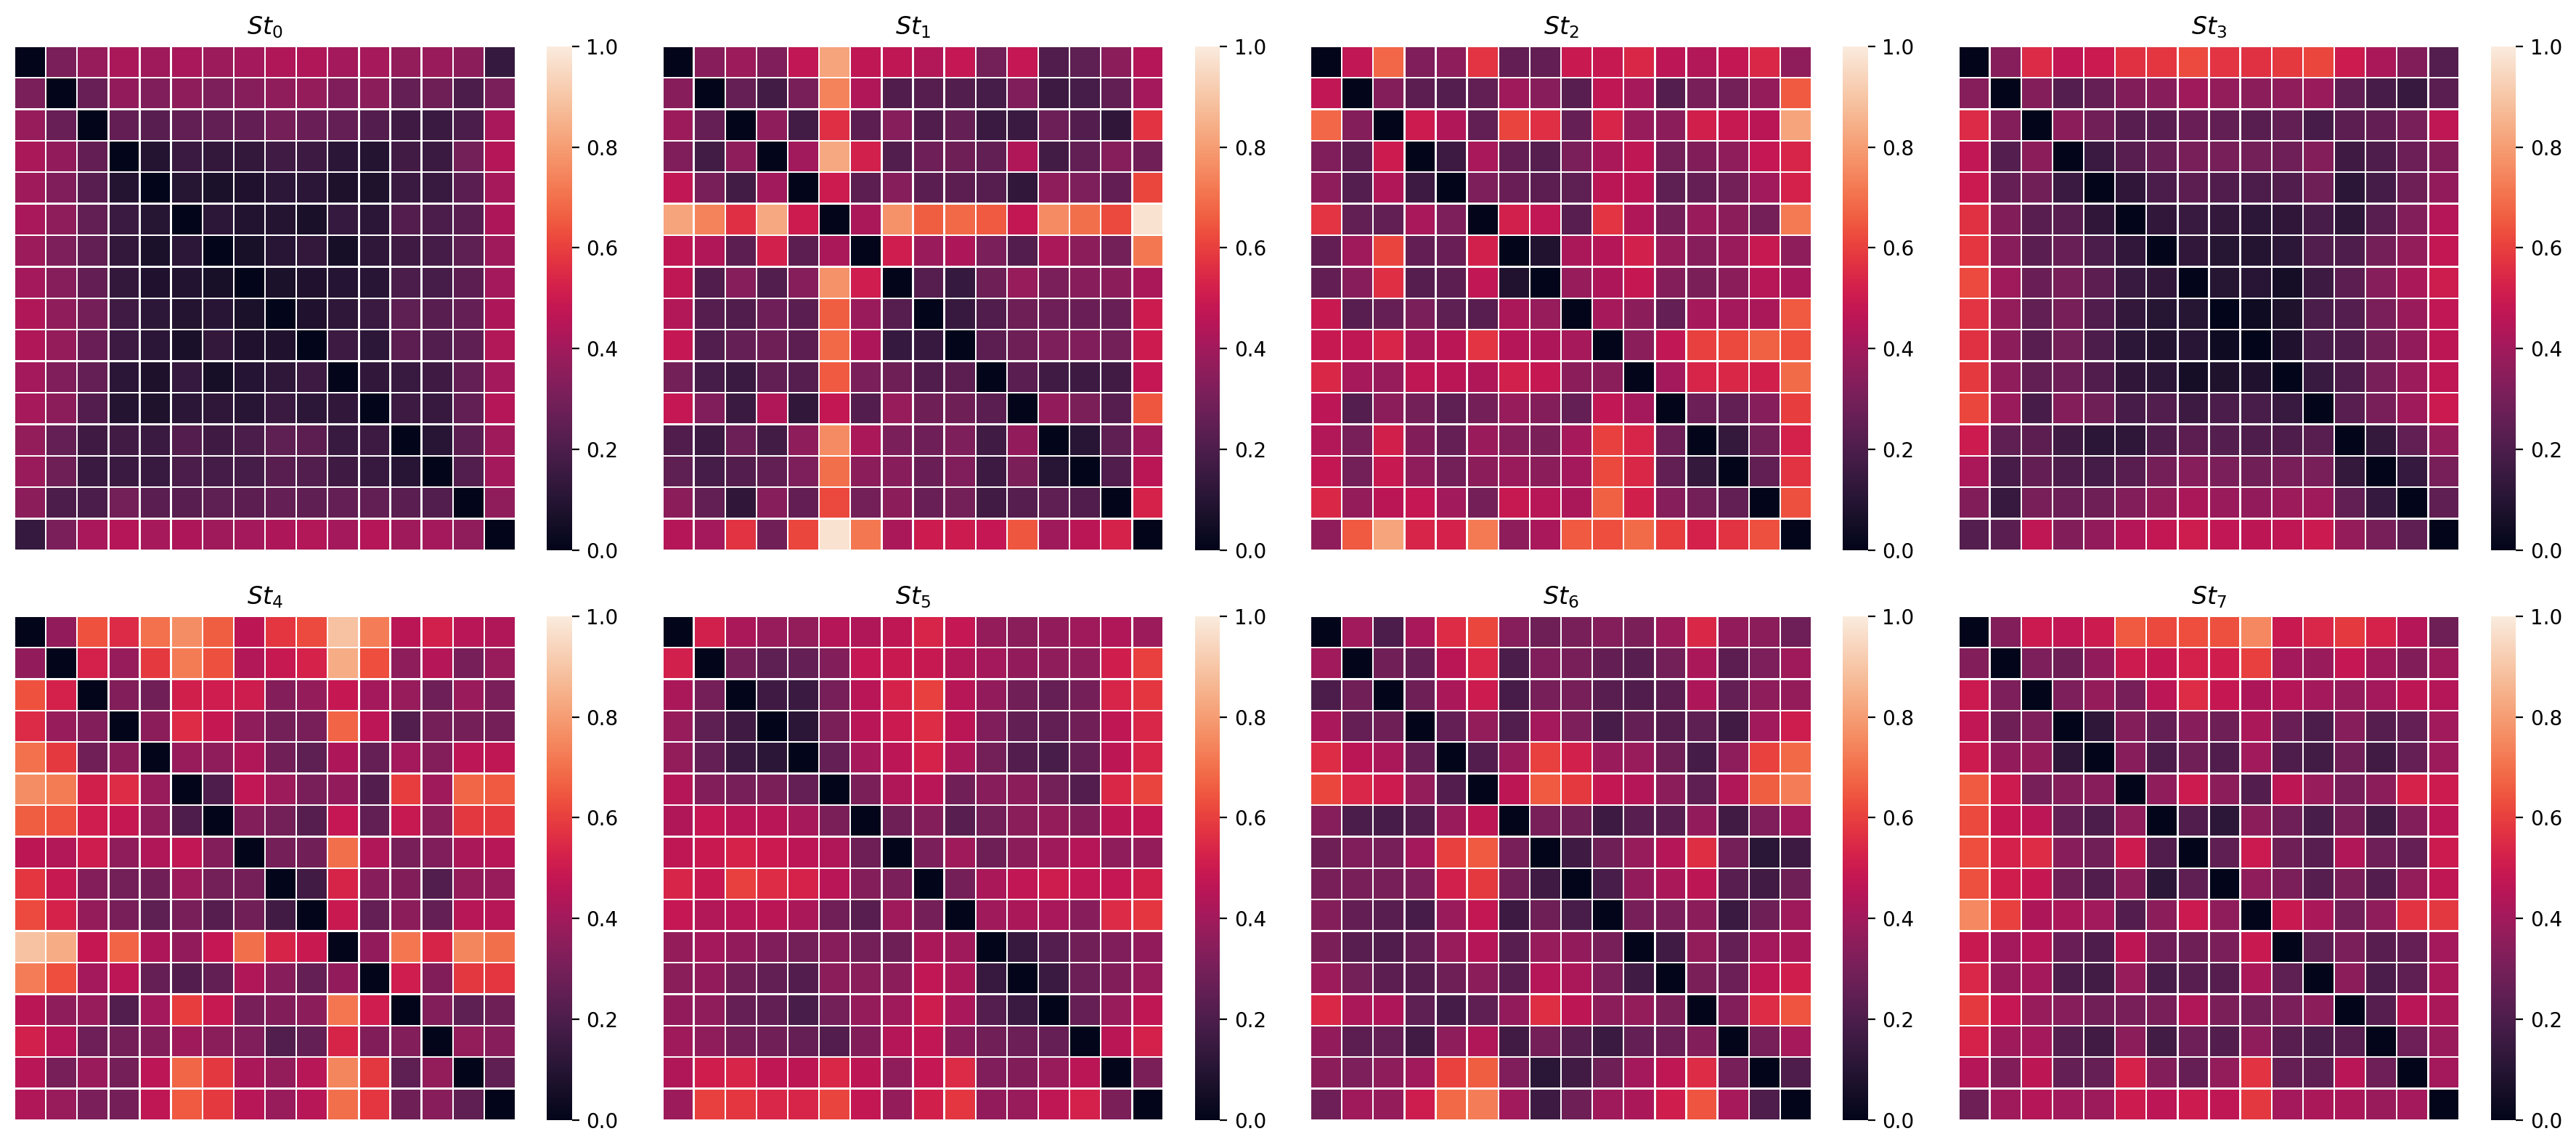

In [57]:
labels_res = [r'$res_{'+str(i)+'}$' for i in range(16)]

fig, ax = myplt.get_axes(l, max_col=4, res=200, fig_frame=(4.5,4))

for k,mt in enumerate(StrSoapLoc_matrix):
    hm = sns.heatmap(StrSoapLoc_matrix[mt], ax=ax[k],
                     vmin=0., vmax=1.,
#                      xticklabels=labels_res, yticklabels=labels_res,
    #                  annot=True, fmt=".2f",
    #                  cbar=False,
                     linewidths=.5, linecolor='w'
                    )

#     hm.set_xticklabels(hm.get_xticklabels(), rotation=60, fontsize = 10)
#     hm.set_yticklabels(hm.get_yticklabels(), rotation=60, fontsize = 10)
    ax[k].set_yticks([])
    ax[k].set_xticks([])
    ax[k].xaxis.set_ticks_position('none')
    ax[k].yaxis.set_ticks_position('none')
    ax[k].set_title(labels[k])
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("soaplocal_distmatrix.svg")

In [81]:
emb_soap_data = { sys: distEmbeddingMDS.fit_transform(StrSoapLoc_matrix[sys]) for sys in StrSoapLoc_matrix}

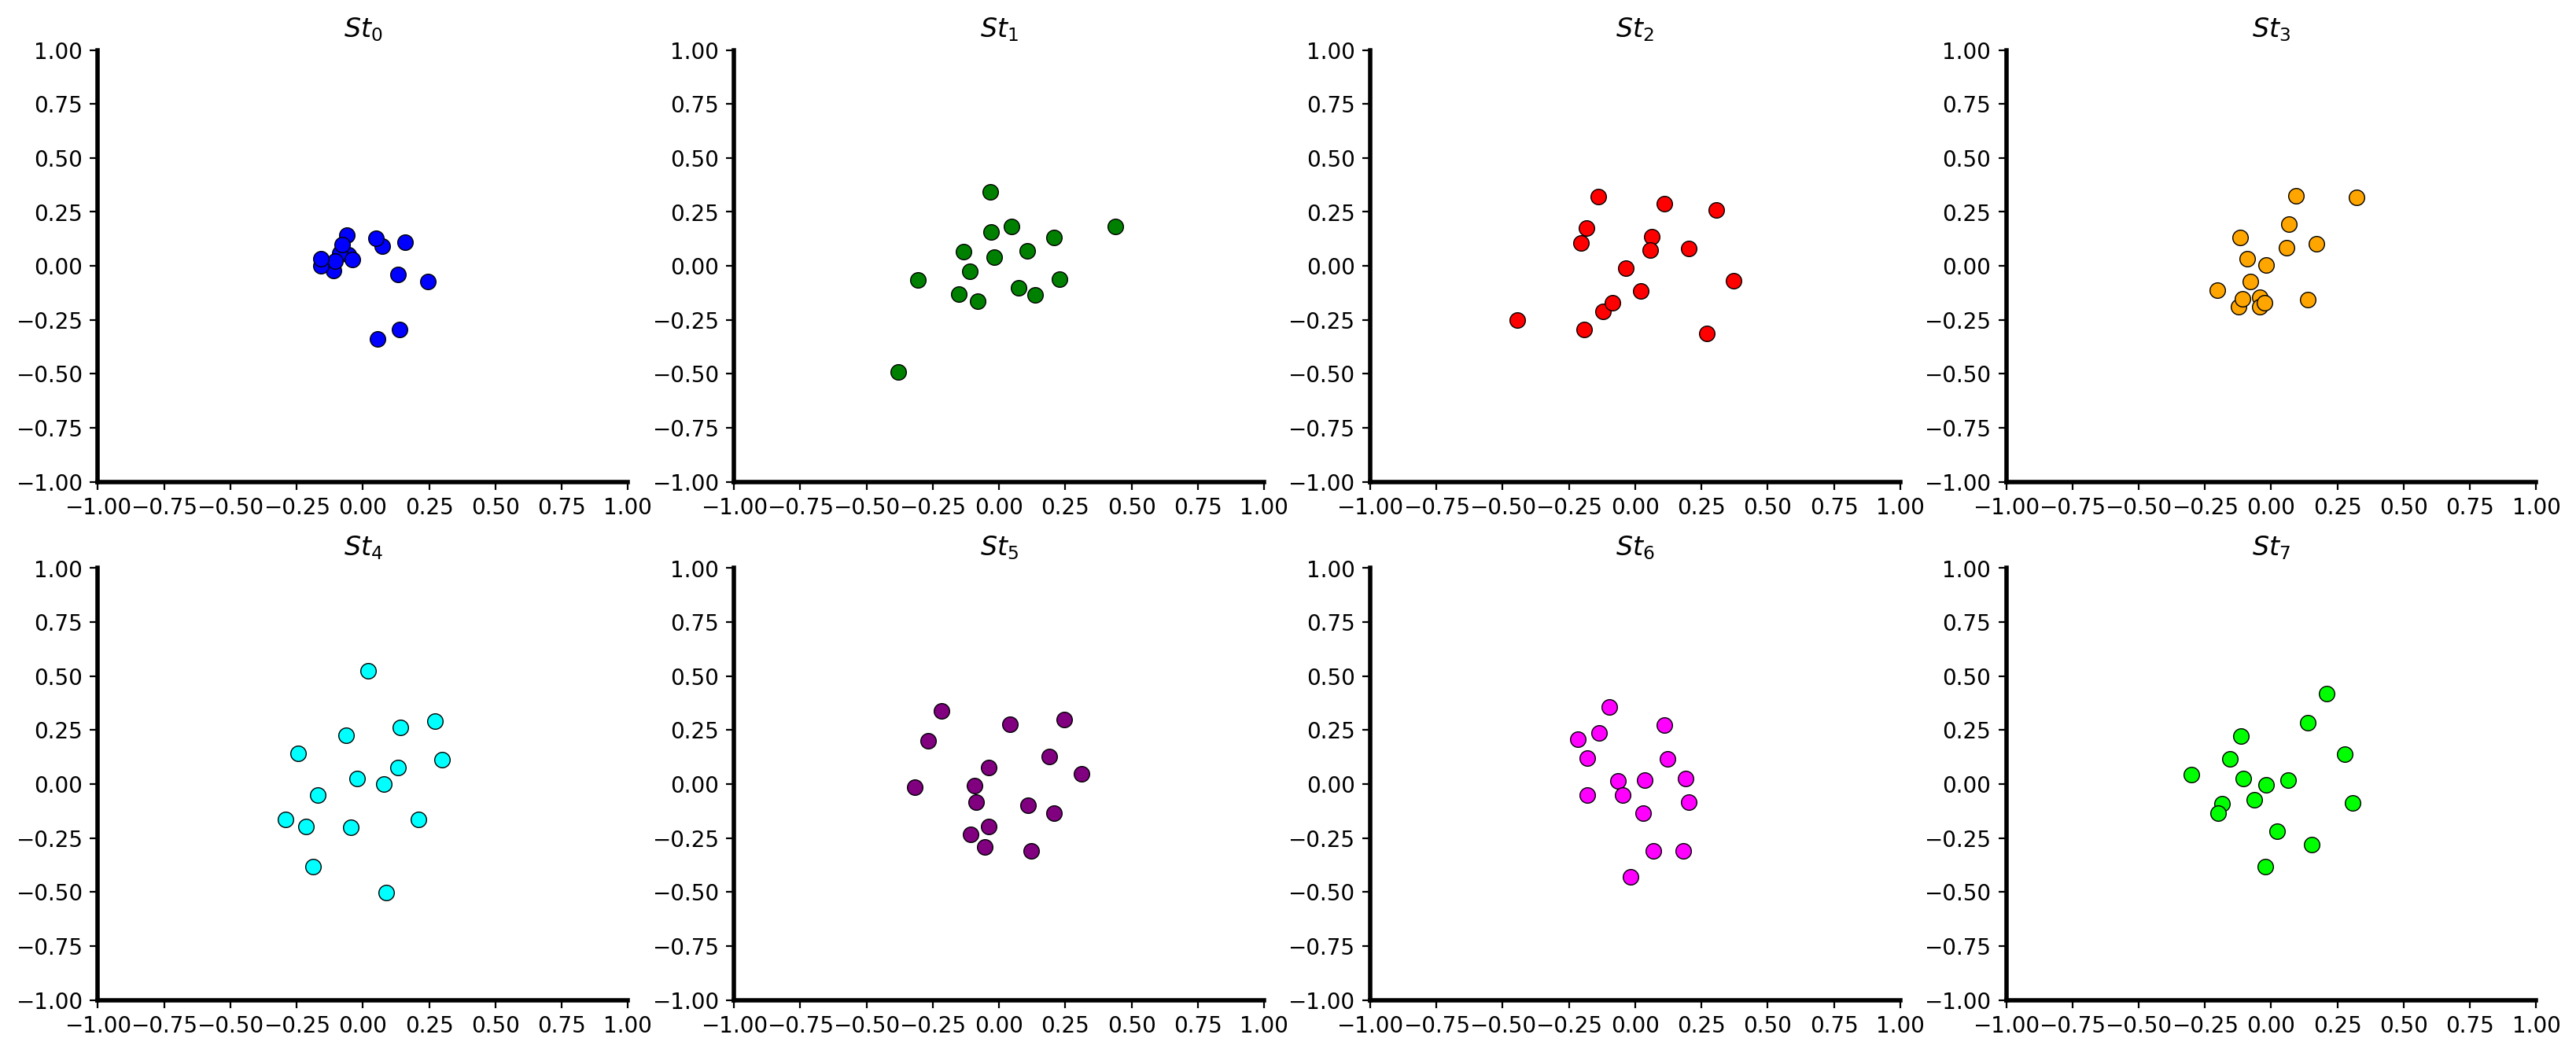

In [82]:
fig, ax = myplt.get_axes(l, max_col=4, res=200)

for k,mt in enumerate(emb_soap_data):
    myplt.single_scatter_axe(emb_soap_data[mt], ax[k], s=50, color=PALETTE[k])
#     myplt.axarrows(fig,ax[k],labels=['',''])
    ax[k].set_title(labels[k])
    ax[k].set_xlim(-1,1)
    ax[k].set_ylim(-1,1)
if SAVE_PLOT:
    plt.savefig("soaplocal_distmatrix_mds.svg")

# Topological approach

In [76]:
FILE_DIR = '../datasets/betaHairpin/'

file_list = []
for entry in os.listdir(FILE_DIR):
    if os.path.isfile(os.path.join(FILE_DIR, entry)):
        if entry.endswith('cmatrix'):
            file_list.append(entry)

file_list = sorted(file_list)
print(f"Number of files {len(file_list)}\n")
print(file_list)

Number of files 8

['cluster_0_cmatrix', 'cluster_1_cmatrix', 'cluster_2_cmatrix', 'cluster_3_cmatrix', 'cluster_4_cmatrix', 'cluster_5_cmatrix', 'cluster_6_cmatrix', 'cluster_7_cmatrix']


In [77]:
corr_mtrx = {labels_[i] : np.loadtxt(FILE_DIR+file) for i,file in enumerate(file_list)}

In [78]:
dynm_dist = { corr : (1 - np.abs(corr_mtrx[corr])) for corr in corr_mtrx}

In [63]:
emb_data = { sys: distEmbeddingMDS.fit_transform(dynm_dist[sys]) for sys in dynm_dist }

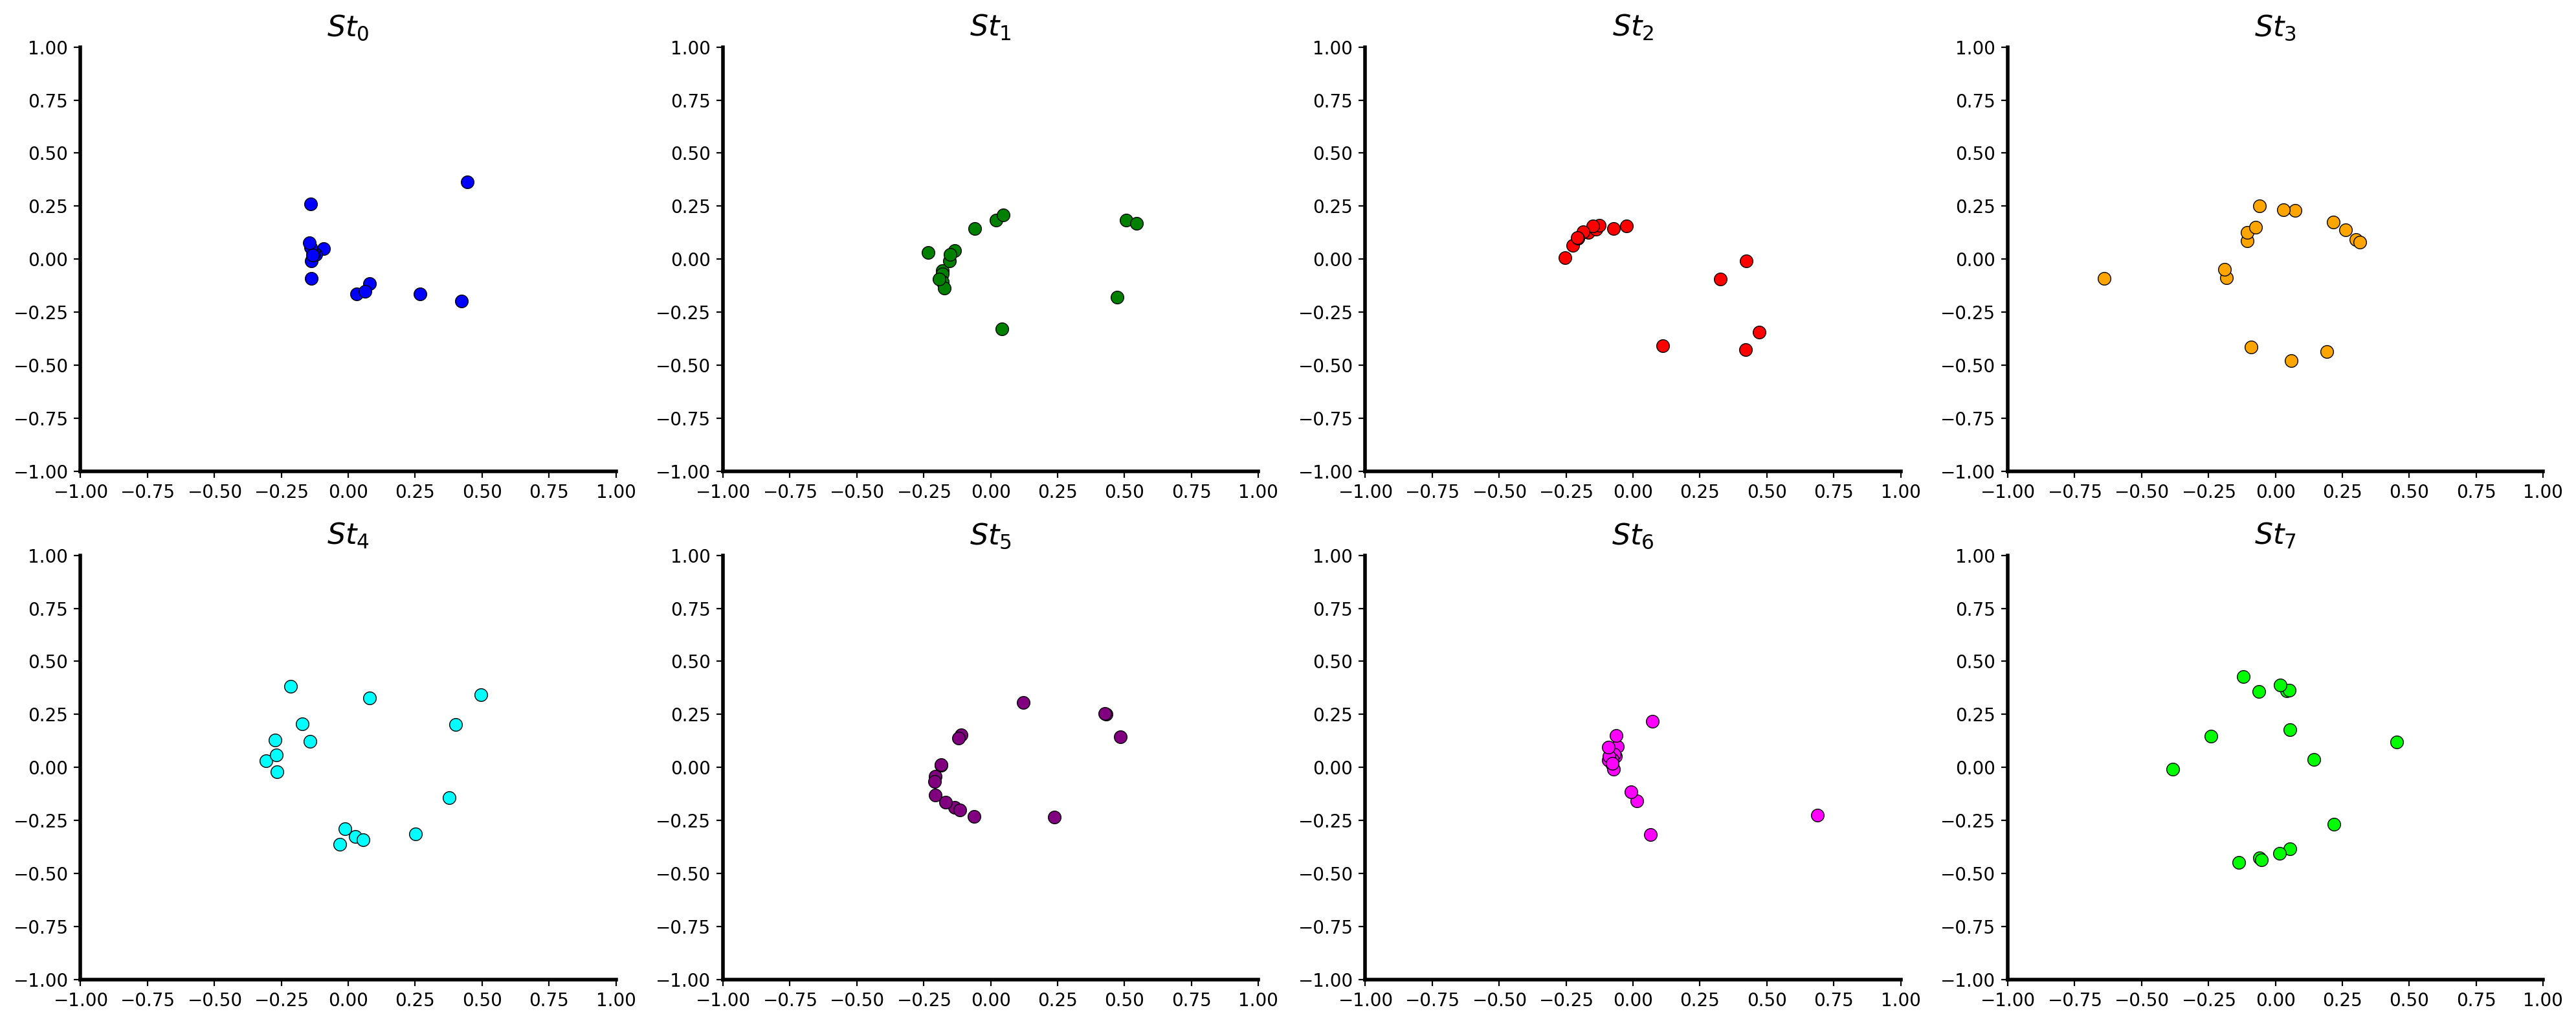

In [74]:
fig, ax = myplt.get_axes(8, max_col=4, res=200)
for i,j in enumerate(emb_data):
    myplt.single_scatter_axe(emb_data[j], ax[i], s=50, color=PALETTE[i])
#     myplt.axarrows(fig,ax[count],labels=['x','y'])
    ax[i].set_title(labels[i], size=16)
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(-1,1)
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("dynam_dists_emb.svg")

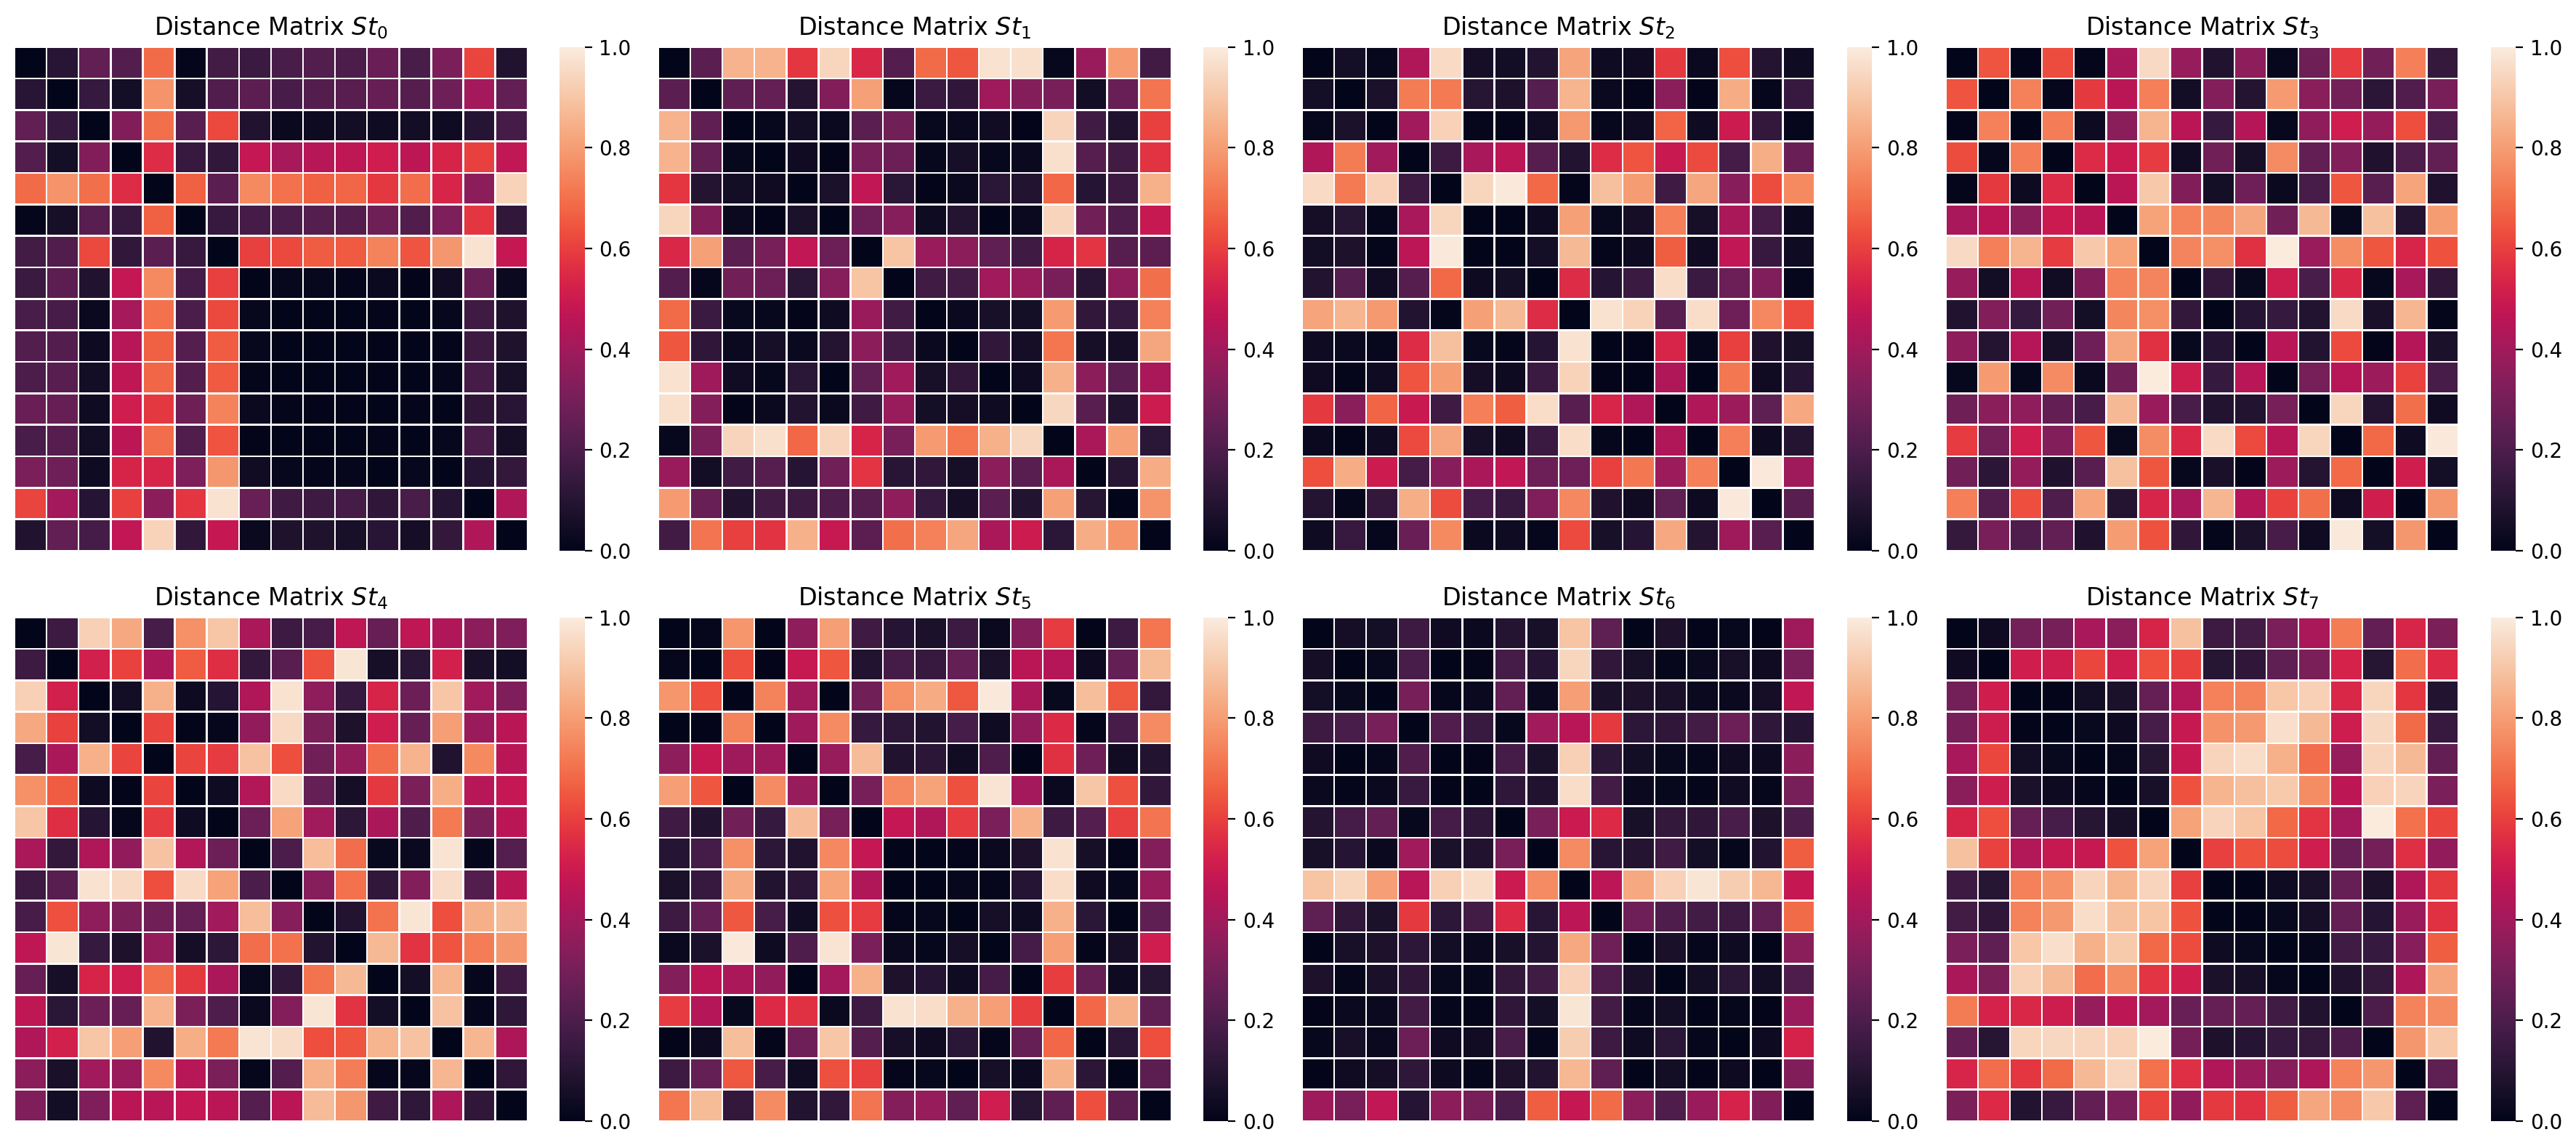

In [134]:
fig, ax = myplt.get_axes(len(dynm_dist), max_col=4, res=200, fig_frame=(4.5,4))

for i,d in enumerate(dynm_dist):
    sns.heatmap(dynm_dist[d], vmin=0., vmax=1., ax=ax[i], 
                yticklabels=False, xticklabels=False,
                linewidths=.5, linecolor='w')
    ax[i].set_title("Distance Matrix "+labels[i])
    fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("dynamdist_matrix.svg")

## Topological methods

In [84]:
# skeleton graph

MEL = 1.0
skeletons = {
    dset: mytop.get_skeleton_from_mtrx(dynm_dist[dset],MEL) for dset in dynm_dist
#     dset: mytop.get_skeleton(emb_data[dset],MEL) for dset in emb_data

}
skeletons

{'St_0': <gudhi.rips_complex.RipsComplex at 0x7f2f38c3b2a0>,
 'St_1': <gudhi.rips_complex.RipsComplex at 0x7f2f38c3b6b0>,
 'St_2': <gudhi.rips_complex.RipsComplex at 0x7f2f38c3b920>,
 'St_3': <gudhi.rips_complex.RipsComplex at 0x7f2f3944b030>,
 'St_4': <gudhi.rips_complex.RipsComplex at 0x7f2f3944b100>,
 'St_5': <gudhi.rips_complex.RipsComplex at 0x7f2f3944b1d0>,
 'St_6': <gudhi.rips_complex.RipsComplex at 0x7f2f3944b2a0>,
 'St_7': <gudhi.rips_complex.RipsComplex at 0x7f2f3944b370>}

In [85]:
# VR complex

MAX_DIM = 2
VRcomplexes = {
    sk: mytop.get_VRcomplex(skeletons[sk],MAX_DIM) for sk in skeletons
}
VRcomplexes

{'St_0': <gudhi.simplex_tree.SimplexTree at 0x7f2f386183f0>,
 'St_1': <gudhi.simplex_tree.SimplexTree at 0x7f2f38618750>,
 'St_2': <gudhi.simplex_tree.SimplexTree at 0x7f2f386181b0>,
 'St_3': <gudhi.simplex_tree.SimplexTree at 0x7f2f38618f90>,
 'St_4': <gudhi.simplex_tree.SimplexTree at 0x7f2f38618ba0>,
 'St_5': <gudhi.simplex_tree.SimplexTree at 0x7f2f38618900>,
 'St_6': <gudhi.simplex_tree.SimplexTree at 0x7f2f38618360>,
 'St_7': <gudhi.simplex_tree.SimplexTree at 0x7f2f386185a0>}

In [86]:
# Persistence pairs

barCodes = {
    vr: mytop.get_barCode(VRcomplexes[vr]) for vr in VRcomplexes
}
barCodes.keys()

dict_keys(['St_0', 'St_1', 'St_2', 'St_3', 'St_4', 'St_5', 'St_6', 'St_7'])

### Visual results

In [87]:
def barcode_dimension(barcode, dimension, sort=True):
    brc_tmp = []
    if sort:
        barcode = sorted(barcode)
    for entry in barcode:
        if entry[0] == dimension:
            brc_tmp.append(entry)
    return brc_tmp

In [88]:
VISUAL = ['St_0', 'St_3']

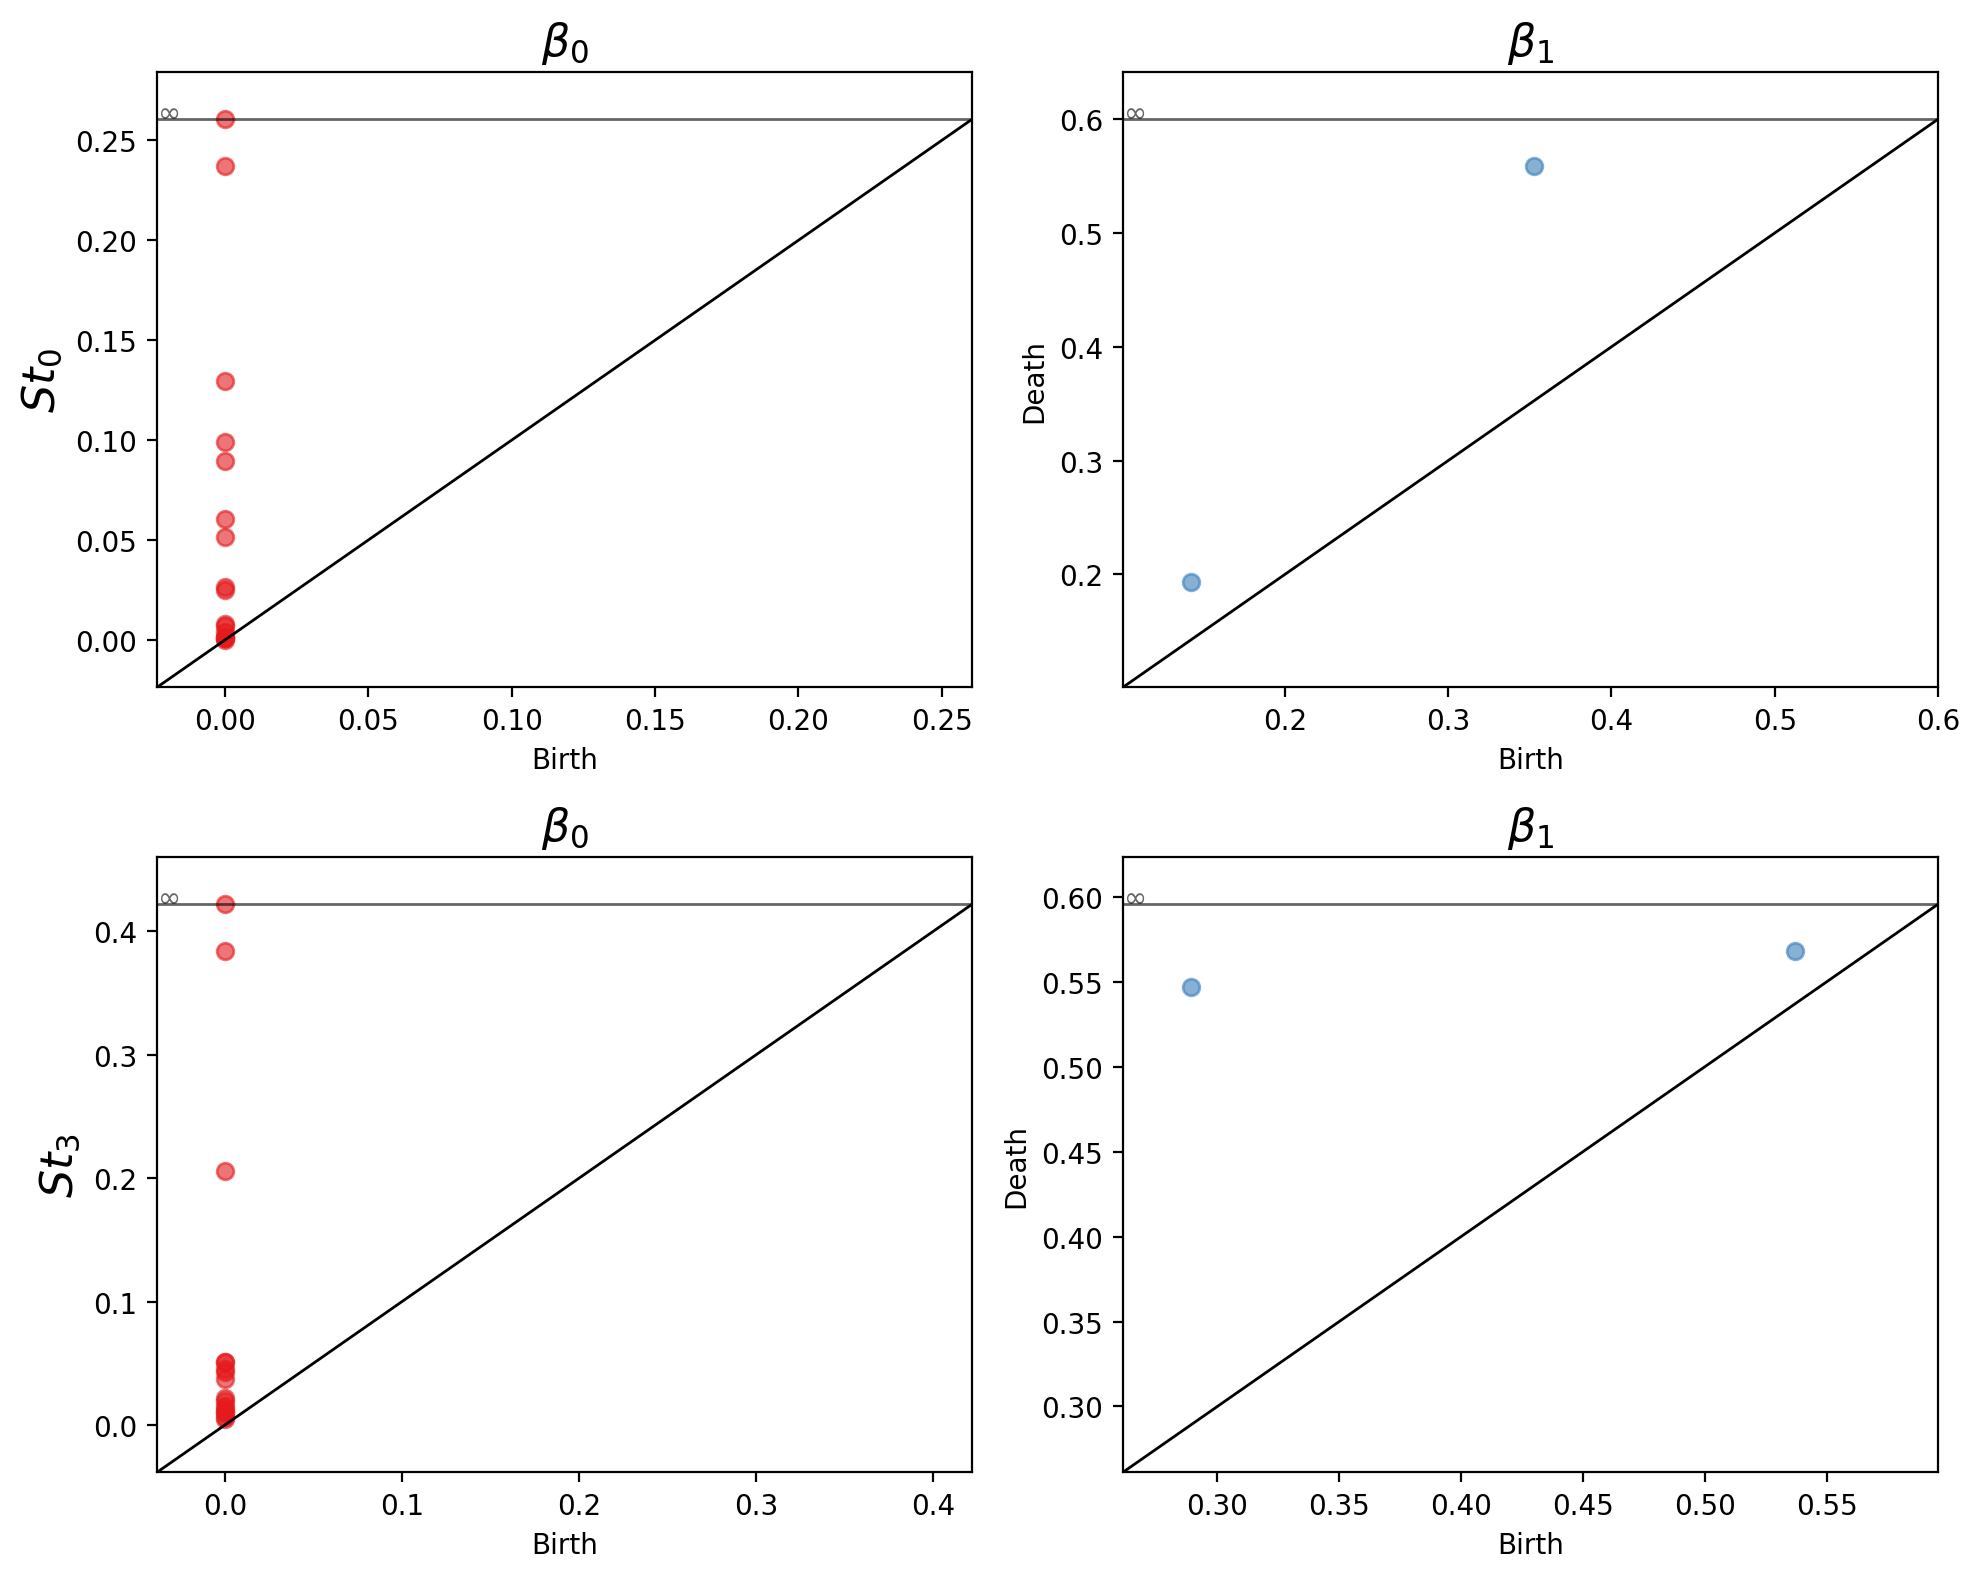

In [104]:
dimensions = np.arange(MAX_DIM)
count=0

fig, ax = myplt.get_axes(len(VISUAL)*len(dimensions), max_col=len(dimensions), res=200)
for sys in VISUAL:
    for dim in dimensions:
        brc_ = barcode_dimension(barCodes[sys], dim, sort=False)
        gd.plot_persistence_diagram(brc_, axes=ax[count])
        ax[count].set_title(r'$\beta_'+str(dim)+'$', size=16)
#         for side in ['right','top']:
#             ax[count].spines[side].set_visible(False)        
        count+=1
ax[0].set_ylabel(r'$'+VISUAL[0]+'$', size=16)
ax[0+len(dimensions)].set_ylabel(r'$'+VISUAL[1]+'$', size=16)
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("persistence_diagram.svg")

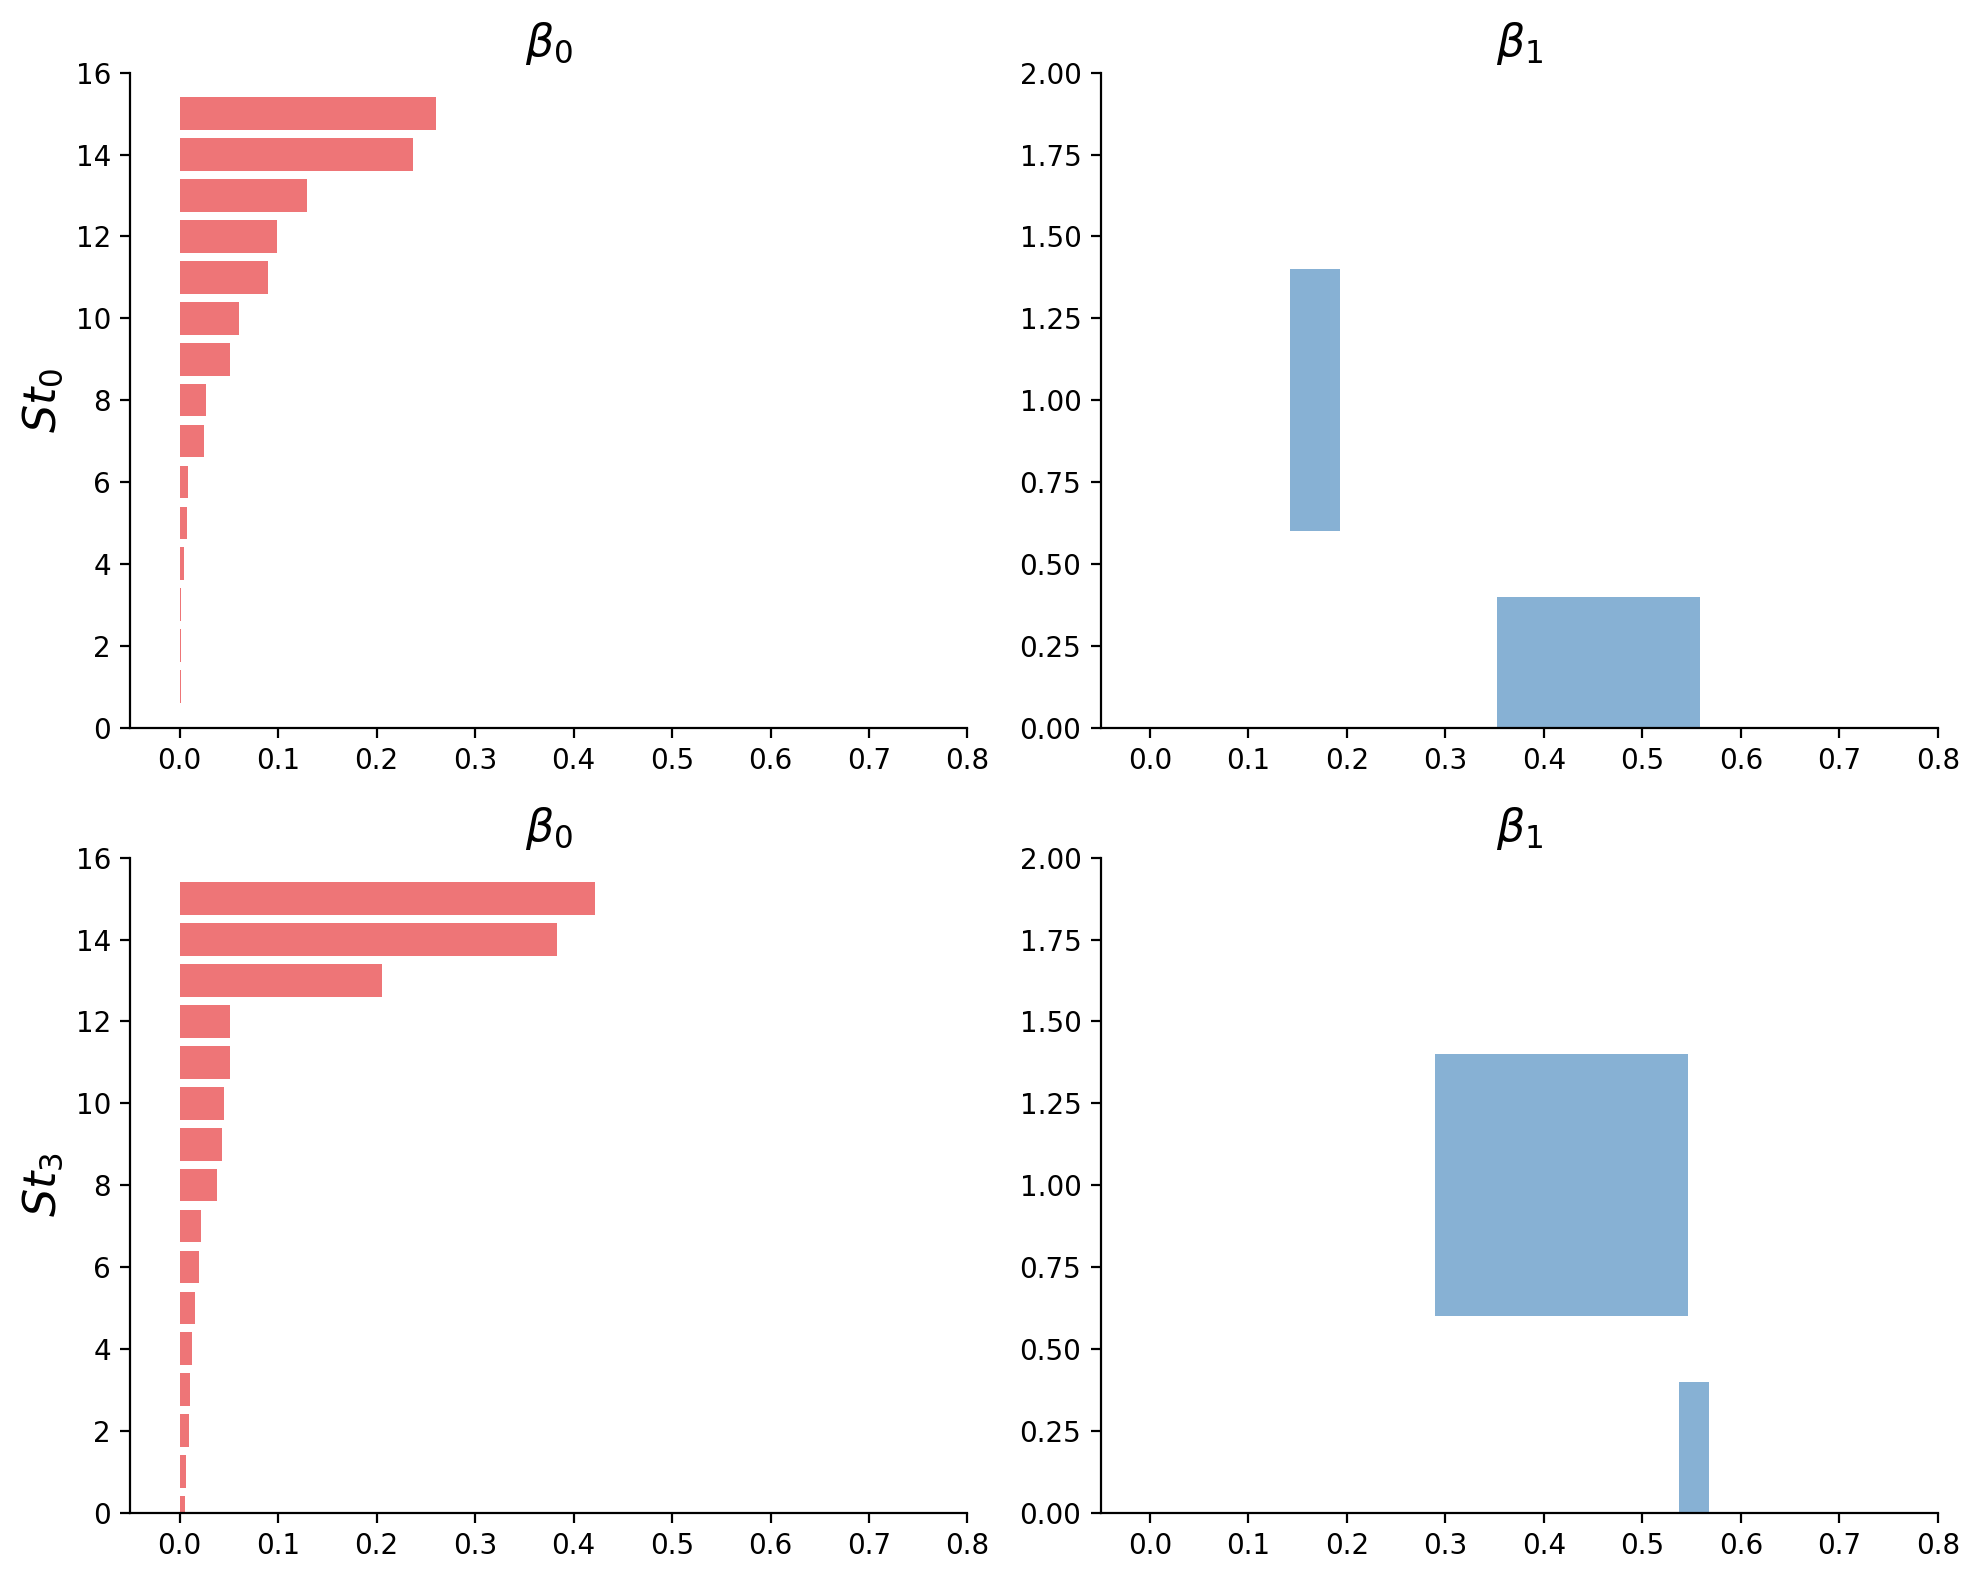

In [103]:
count=0

fig, ax = myplt.get_axes(len(VISUAL)*len(dimensions), max_col=len(dimensions), res=200)
for sys in VISUAL:
    for dim in dimensions:
        brc_ = barcode_dimension(barCodes[sys], dim, sort=False)
        gd.plot_persistence_barcode(persistence=brc_, legend=False, axes=ax[count])
        ax[count].set_title(r'$\beta_'+str(dim)+'$', size=16)
        ax[count].set_xlim((-0.05,0.8))
        for side in ['right','top']:
            ax[count].spines[side].set_visible(False)
        count+=1
ax[0].set_ylabel(r'$'+VISUAL[0]+'$', size=16)
ax[0+len(dimensions)].set_ylabel(r'$'+VISUAL[1]+'$', size=16)
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("barcode_matrix.svg")

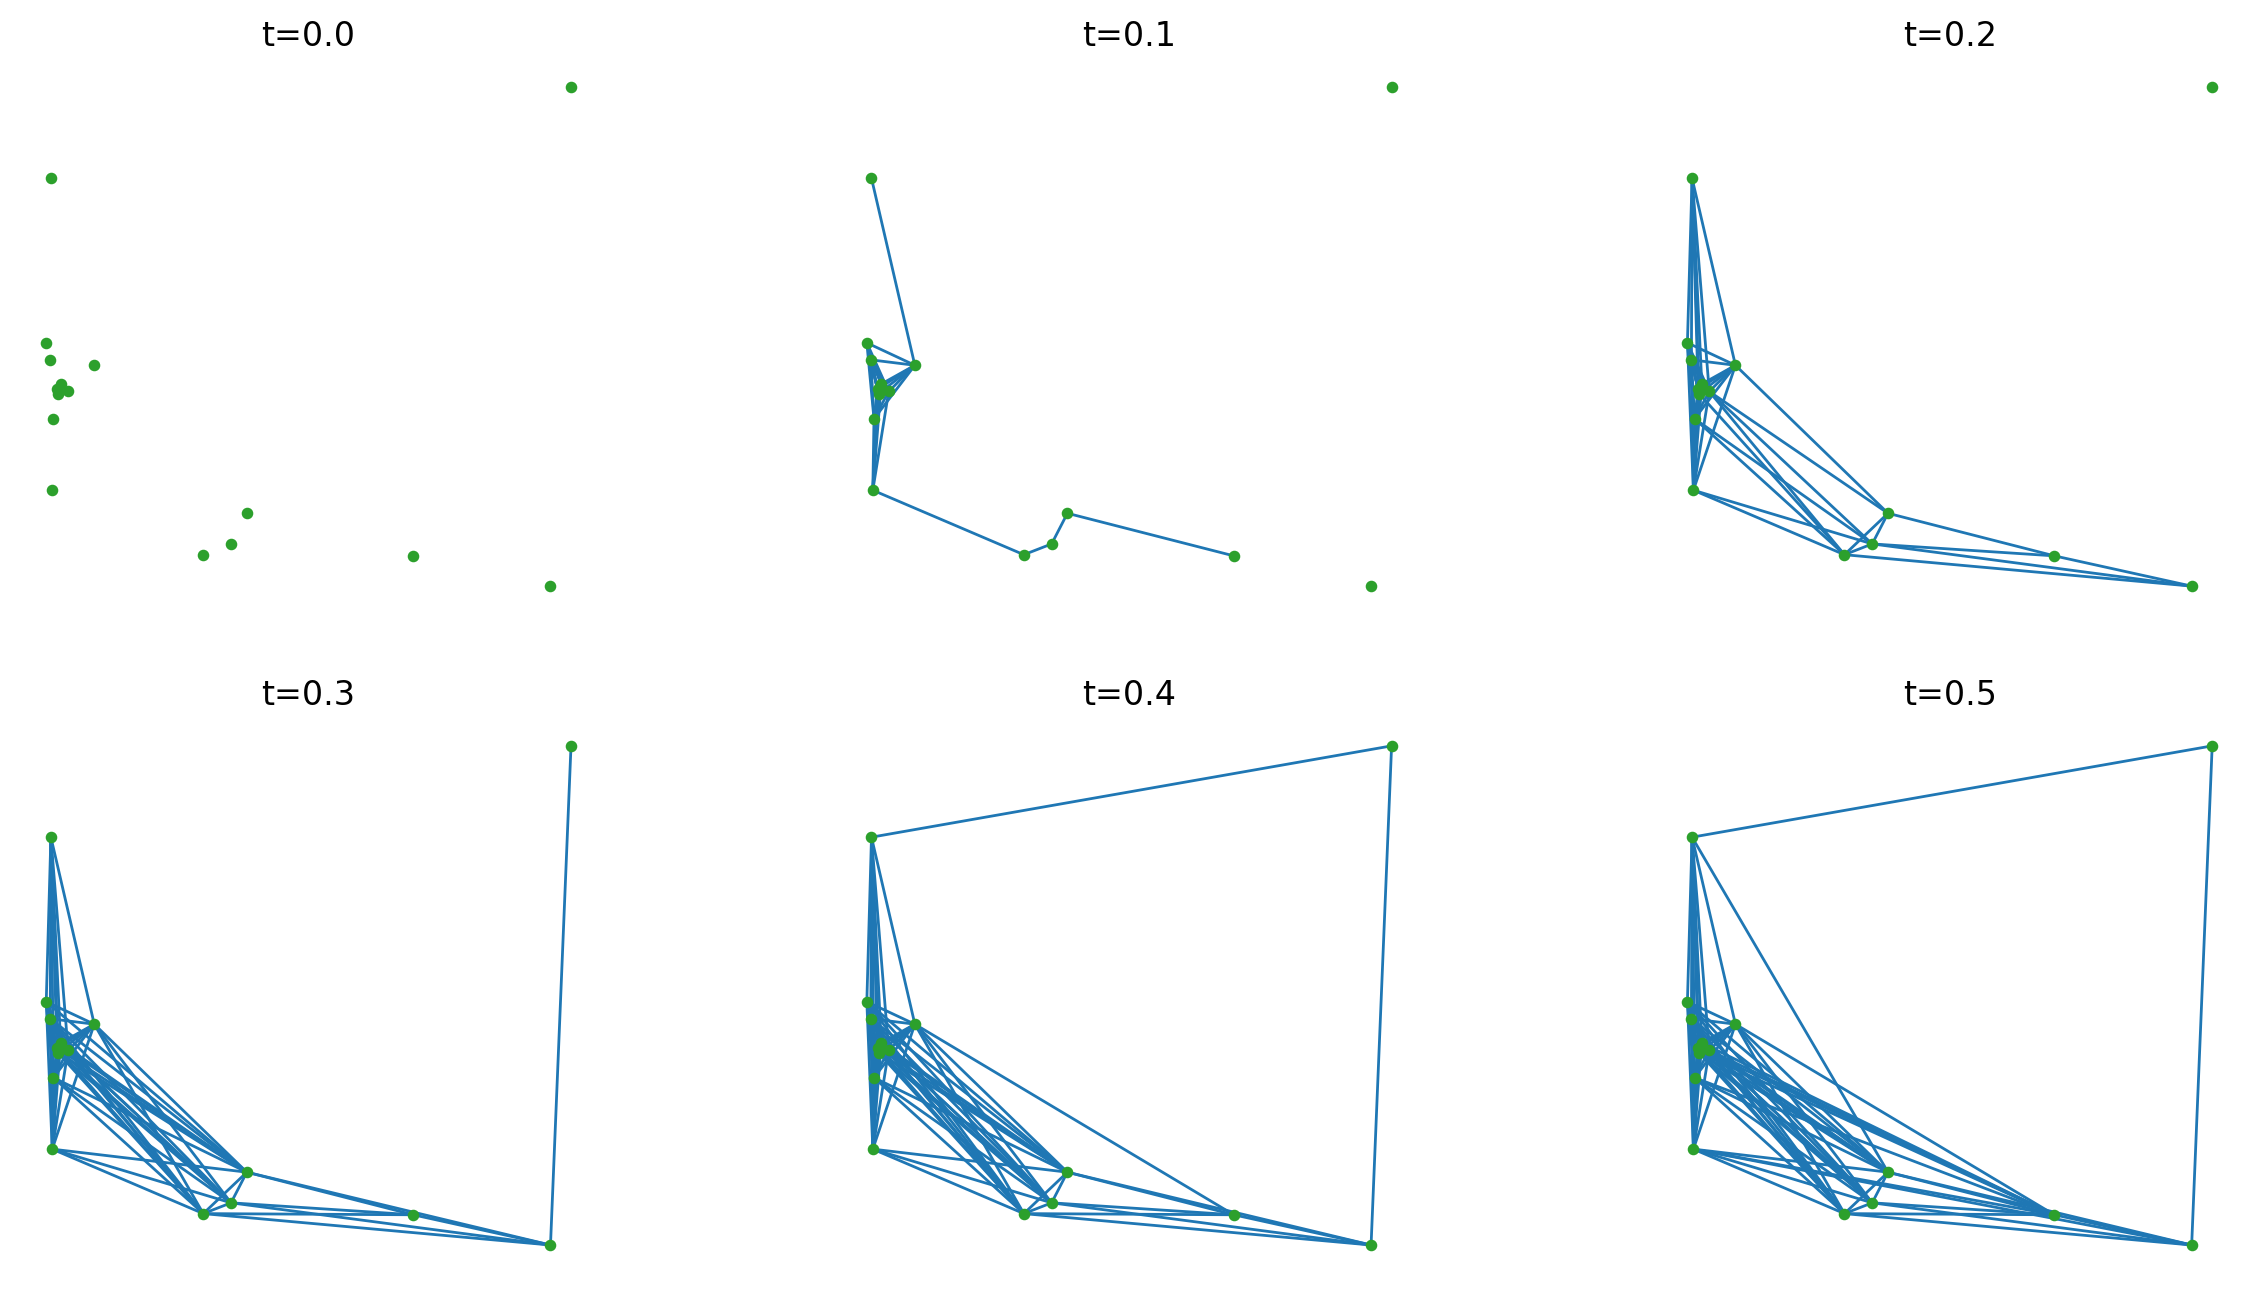

In [114]:
filtration_cycle = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
fig, ax = myplt.get_axes(len(filtration_cycle), max_col=3, res=200)
for i,fil in enumerate(filtration_cycle):
    filtration = mytop.get_filtration(emb_data['St_0'],VRcomplexes['St_0'],r=fil)
    mytop.plt_filtration(emb_data['St_0'], filtration, r=fil, dotsize=10, axes=ax[i])
    ax[i].set_title(r't='+str(fil))
    ax[i].set_aspect('equal')
if SAVE_PLOT:
    plt.savefig("filtration_example_1.svg")

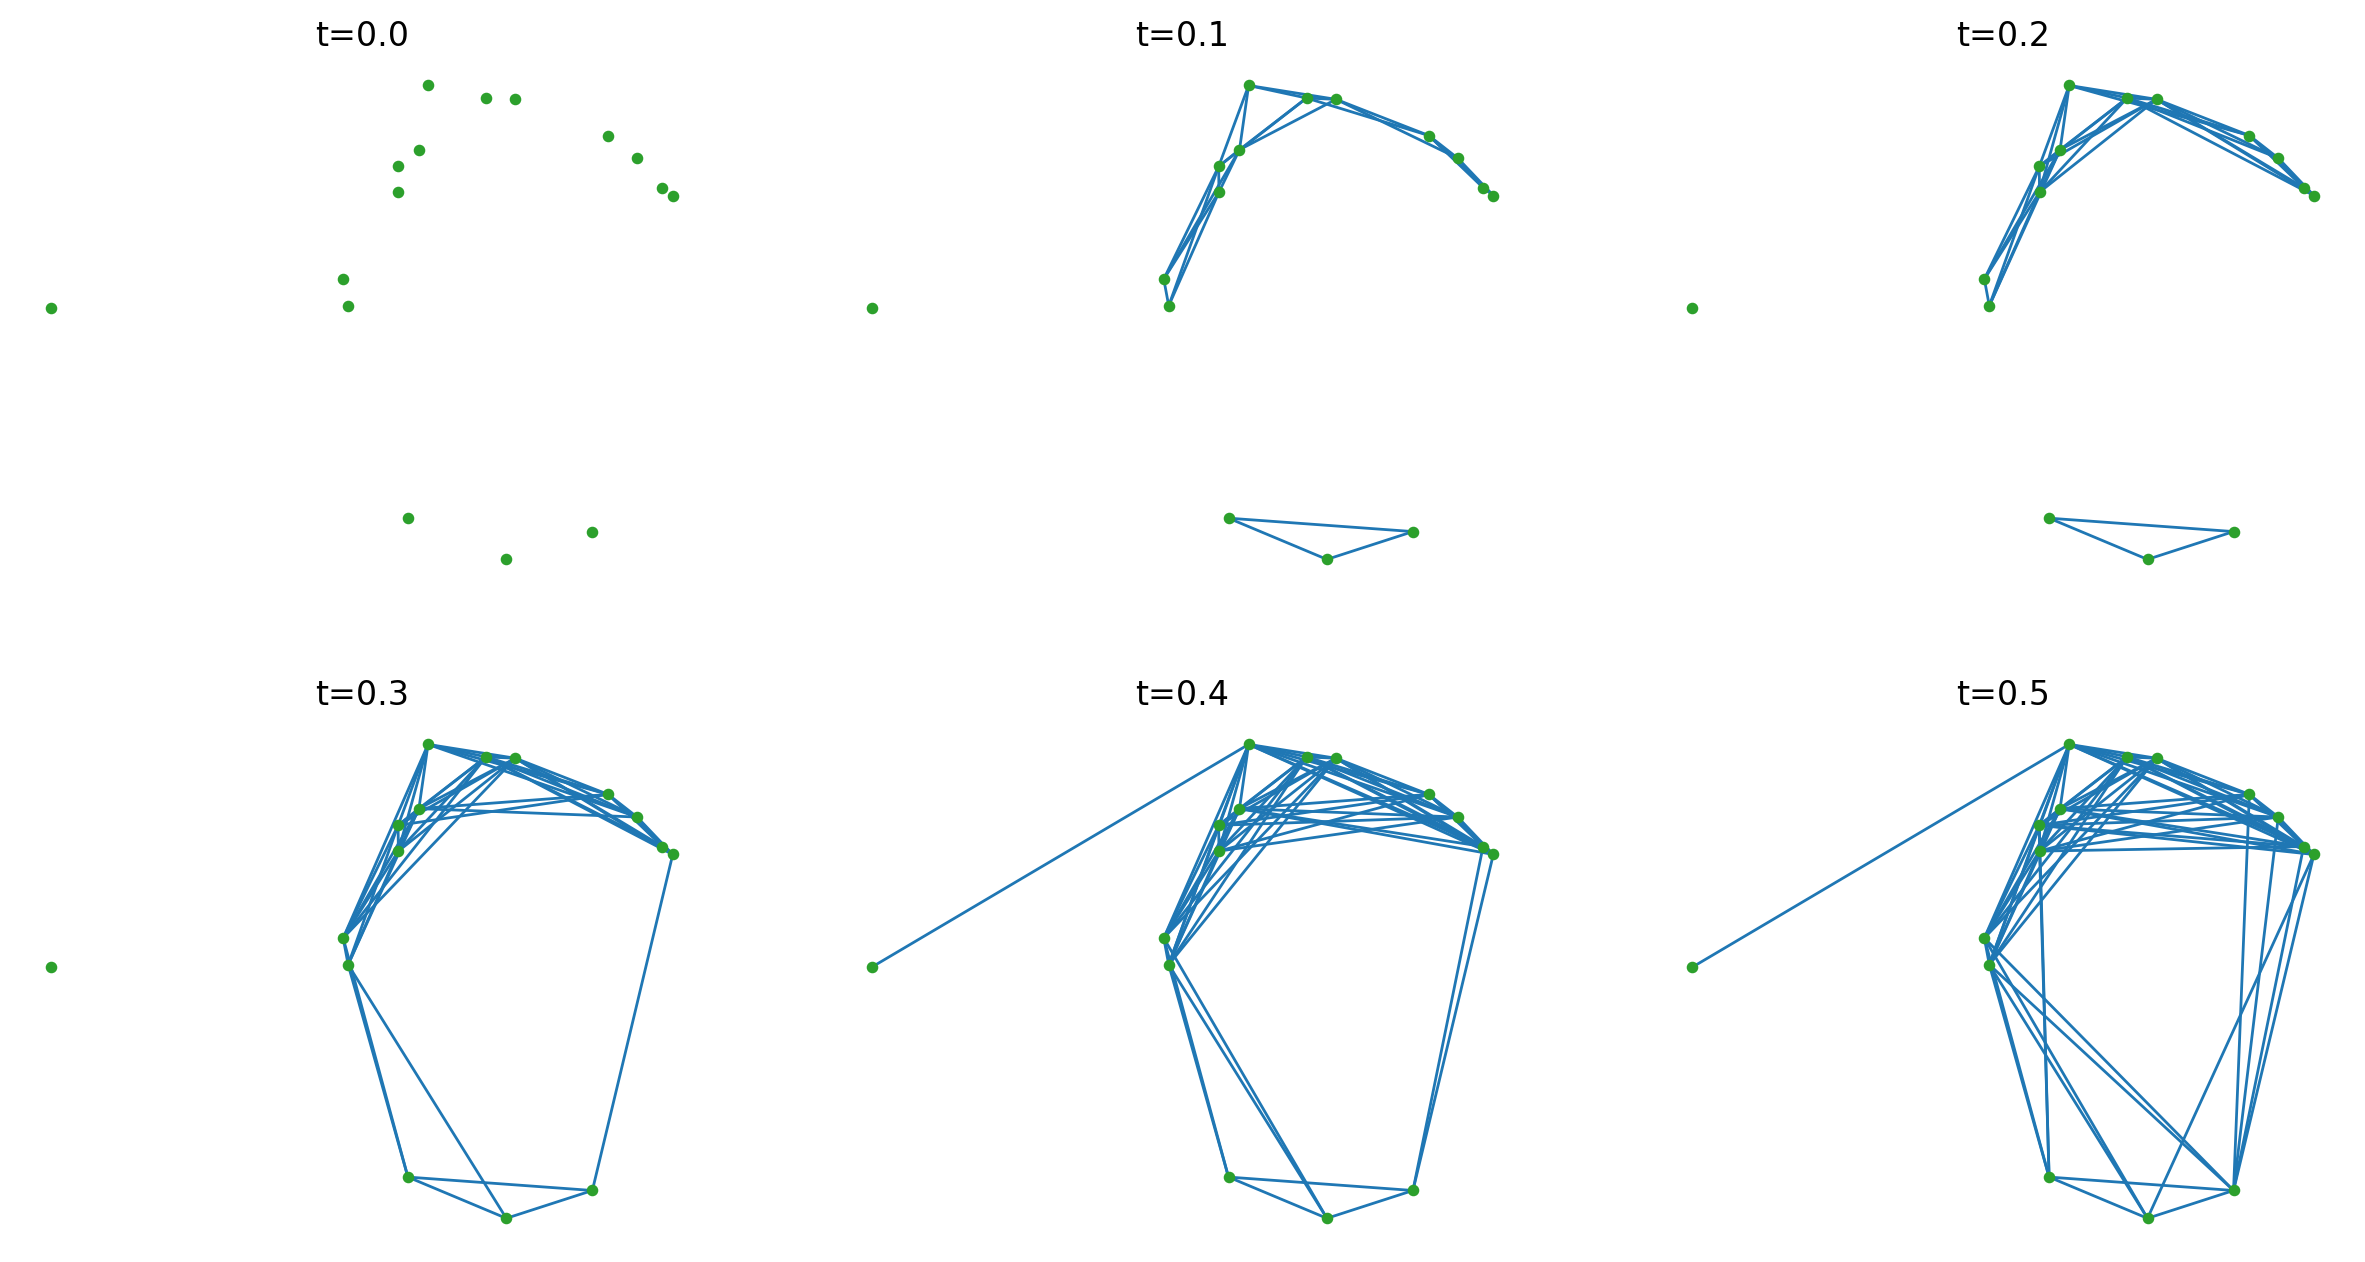

In [115]:
filtration_cycle = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
fig, ax = myplt.get_axes(len(filtration_cycle), max_col=3, res=200)
for i,fil in enumerate(filtration_cycle):
    filtration = mytop.get_filtration(emb_data['St_3'],VRcomplexes['St_3'],r=fil)
    mytop.plt_filtration(emb_data['St_3'], filtration, r=fil, dotsize=10, axes=ax[i])
    ax[i].set_title(r't='+str(fil))
    ax[i].set_aspect('equal')
if SAVE_PLOT:
    plt.savefig("filtration_example_2.svg")

In [116]:
RES = 500
silhouettes_dim0 = {
    vr: mytop.get_silhouette_new(VRcomplexes[vr], res=RES, dim=0) for vr in VISUAL
}

silhouettes_dim1 = {
    vr: mytop.get_silhouette_new(VRcomplexes[vr], res=RES) for vr in VISUAL
}

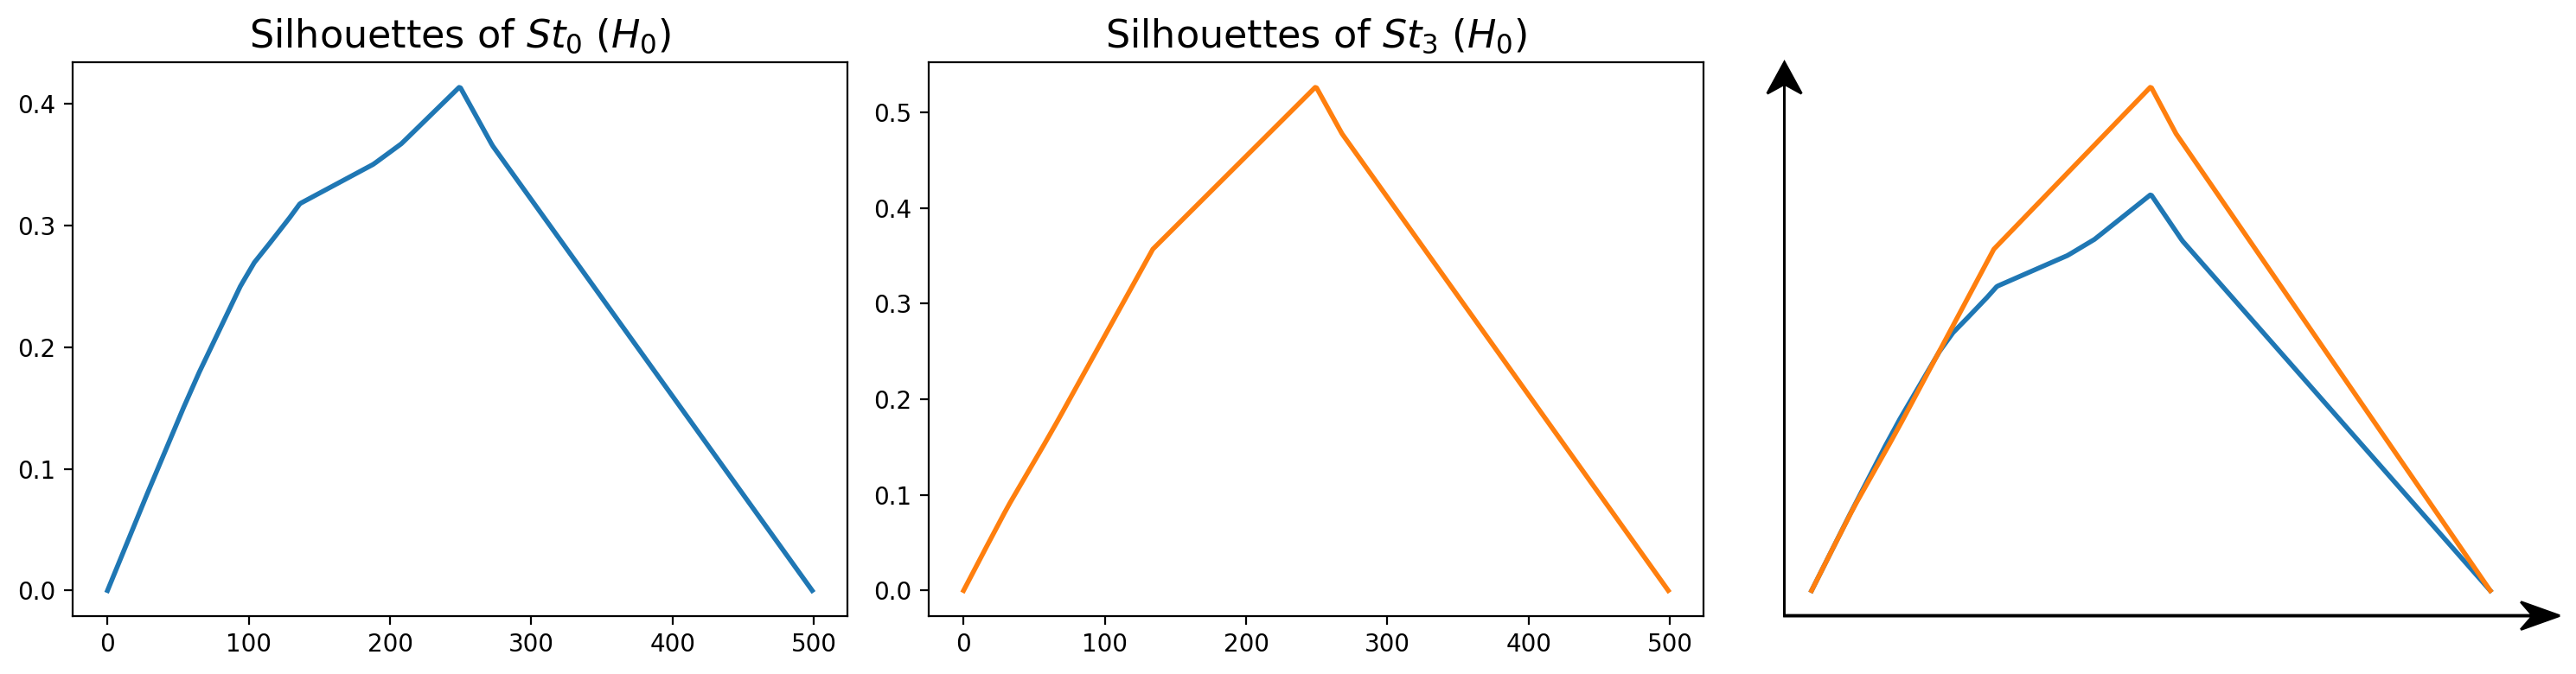

In [154]:
palette = myplt.myPalette(2, palette='tab10')
fig, ax = myplt.get_axes(len(silhouettes_dim0)+1, max_col=3, res=200)
for i,j in enumerate(silhouettes_dim0):
    ax[i].plot(silhouettes_dim0[j][0], linewidth=2, c=palette[i])
    ax[i].set_title(r'Silhouettes of $'+j+'$ $(H_0)$', size=16)
    ax[2].plot(silhouettes_dim0[j][0], linewidth=2, c=palette[i])
ax[2].set_xlim((-20,550))
myplt.axarrows(fig,ax[2])
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("sil_dim0.svg")

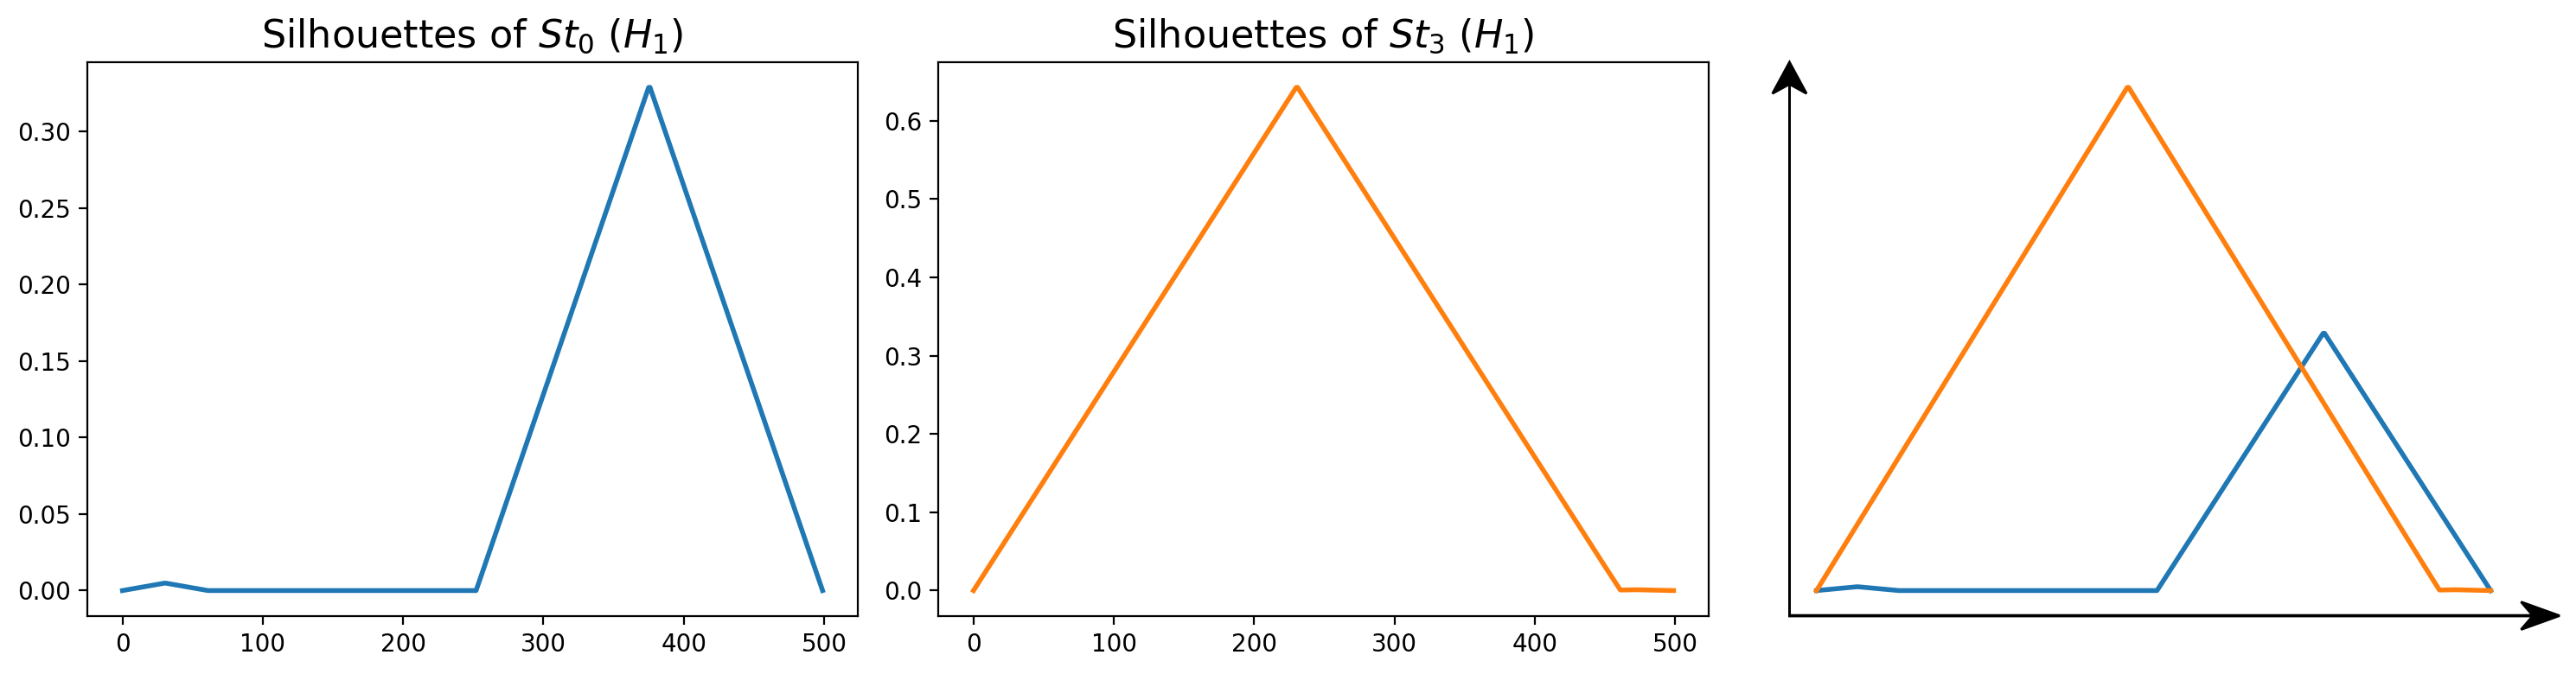

In [155]:
palette = myplt.myPalette(2, palette='tab10')
fig, ax = myplt.get_axes(len(silhouettes_dim1)+1, max_col=3, res=200)
for i,j in enumerate(silhouettes_dim1):
    ax[i].plot(silhouettes_dim1[j][0], linewidth=2, c=palette[i])
    ax[i].set_title(r'Silhouettes of $'+j+'$ $(H_1)$', size=16)
    ax[2].plot(silhouettes_dim1[j][0], linewidth=2, c=palette[i])
ax[2].set_xlim((-20,550))
myplt.axarrows(fig,ax[2])
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("sil_dim1.svg")

In [119]:
persistence_list0 = []
persistence_list1 = []

for i,vrc in enumerate(VRcomplexes):
    print(vrc)
    persistence_list0.append(VRcomplexes[vrc].persistence_intervals_in_dimension(0))
    persistence_list1.append(VRcomplexes[vrc].persistence_intervals_in_dimension(1))

St_0
St_1
St_2
St_3
St_4
St_5
St_6
St_7


In [120]:
l = len(VRcomplexes)
print(f"Number of systems: {l}")
B0 = np.zeros((l, l))
B1 = np.zeros((l, l))

Number of systems: 8


In [121]:
for i in range(l):
    for j in range(i):
        B0[i,j] = gd.bottleneck_distance(persistence_list0[i], persistence_list0[j], 0.001)
        B1[i,j] = gd.bottleneck_distance(persistence_list1[i], persistence_list1[j])
        
B0 = B0 + B0.transpose()
B1 = B1 + B1.transpose()

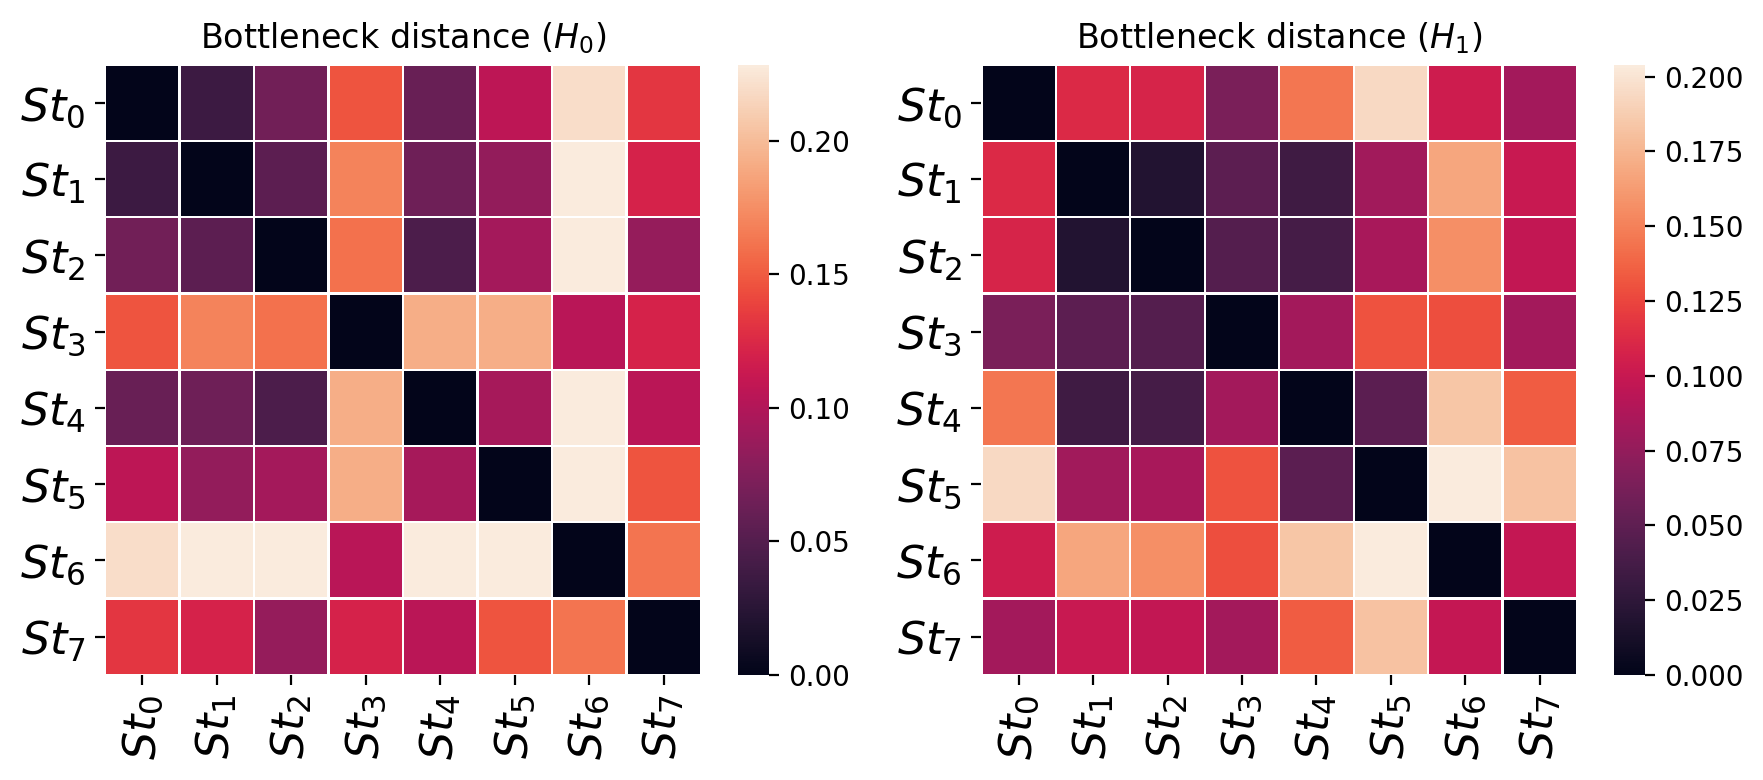

In [159]:
fig, ax = myplt.get_axes(2, max_col=2, res=200, fig_frame=(4.5,4))
hm1 = sns.heatmap(B0, ax=ax[0],
            xticklabels=labels, yticklabels=labels,
            linewidths=.5, linecolor='w'
                 )
hm2 = sns.heatmap(B1, ax=ax[1],
            xticklabels=labels, yticklabels=labels,
            linewidths=.5, linecolor='w'
                 )

hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90, fontsize = 16)
hm1.set_yticklabels(hm1.get_yticklabels(), rotation=0, fontsize = 16)
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90, fontsize = 16)
hm2.set_yticklabels(hm2.get_yticklabels(), rotation=0, fontsize = 16)


ax[0].set_title(r"Bottleneck distance $(H_0)$")
ax[1].set_title(r"Bottleneck distance $(H_1)$")
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("bottleneck_distmatrix.svg")

In [132]:
pos0 = distEmbeddingMDS.fit_transform(B0)
pos1 = distEmbeddingMDS.fit_transform(B1)

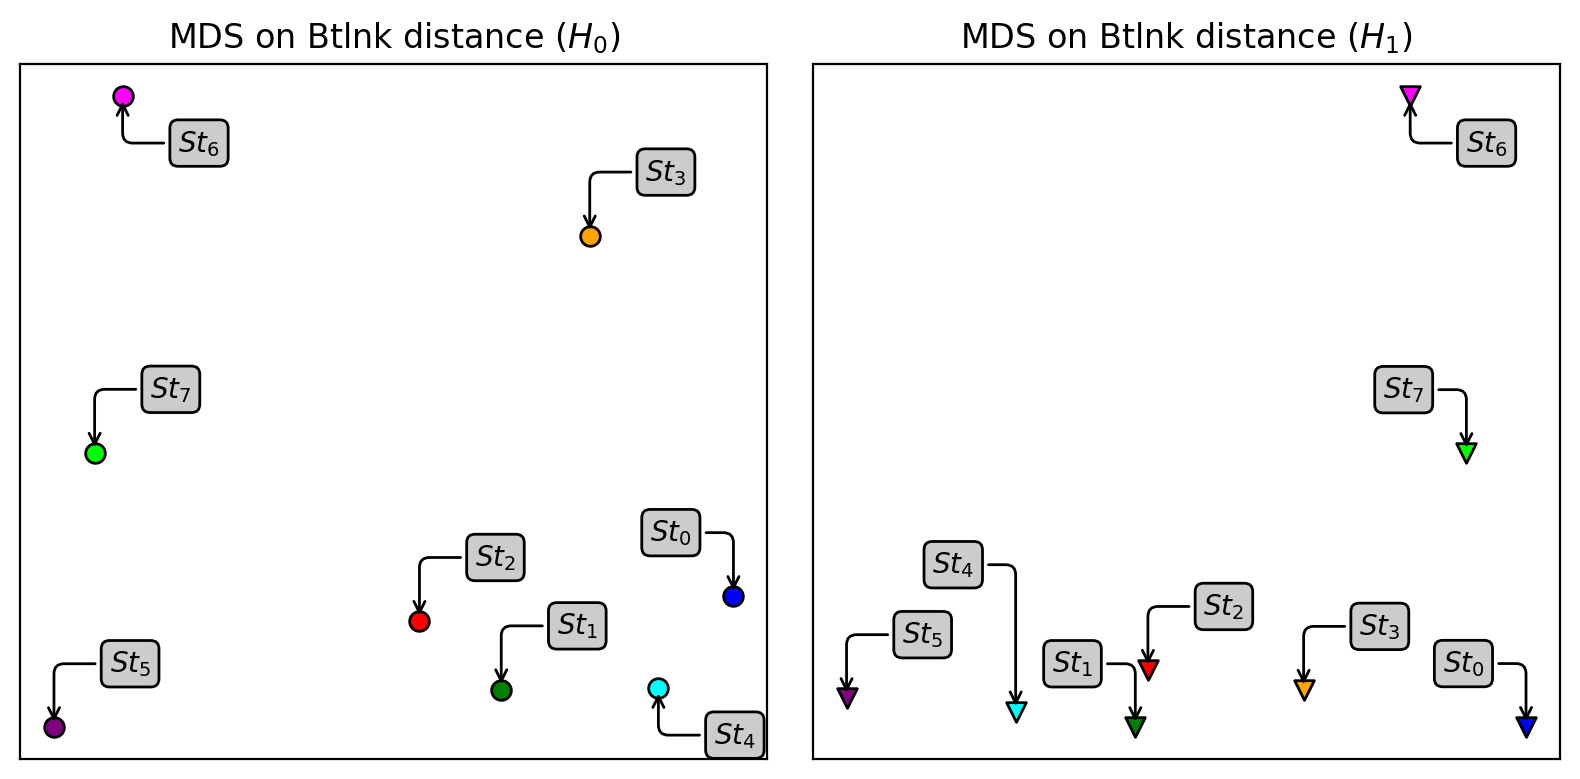

In [165]:
annotate_list = [r'$St_{'+str(i)+'}$' for i in range(len(corr_mtrx))]
annotyx0 = [[-30, 20],[20, 20],[20, 20],[20, 20],[20, -20],[20, 20],[20, -20], [20, 20]]
annotyx1 = [[-30, 20],[-30, 20],[20, 20],[20, 20],[-30, 50],[20, 20],[20, -20], [-30, 20]]

fig, ax = myplt.get_axes(2, max_col=2, res=200, fig_frame=(4,4))
for conf in range(len(file_list)):
    ax[0].scatter(pos0[conf,0], pos0[conf,1], c=PALETTE[conf], s=50, edgecolor='k')
    ax[1].scatter(pos1[conf,0], pos1[conf,1], c=PALETTE[conf], marker='v', s=50, edgecolor='k')
            
# for i, txt in enumerate(annotate_list):
#     ax[0].annotate(txt, (pos0[i,0], pos0[i,1]))
#     ax[1].annotate(txt, (pos1[i,0], pos1[i,1]))

for i, txt in enumerate(annotate_list):
    ax[0].annotate(txt, (pos0[i,0],pos0[i,1]),
                xytext=annotyx0[i], textcoords='offset points',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"))
    ax[1].annotate(txt, (pos1[i,0],pos1[i,1]),
                xytext=annotyx1[i], textcoords='offset points',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"))
    
ax[0].set_title(r"MDS on Btlnk distance $(H_0)$")
ax[1].set_title(r"MDS on Btlnk distance $(H_1)$")
for x in range(2):
    ax[x].set_yticks([])
    ax[x].set_xticks([])
    ax[x].xaxis.set_ticks_position('none')
    ax[x].yaxis.set_ticks_position('none')
fig.tight_layout()
if SAVE_PLOT:
    plt.savefig("bottleneck_distmatrix.svg")